# Anomaly detection in sensor data

In [1]:
## Create a new virtual environment
!python3 -m venv venv
## Activate the virtual environment
!source venv/bin/activate

In [2]:
## Install the required packages
!pip install pandas==2.1.4 numpy==1.26.3 matplotlib==3.8.2 seaborn==0.12.2 plotly==5.22.0 scikit-learn==1.4.0 imblearn==0.0

Defaulting to user installation because normal site-packages is not writeable


In [26]:
import polars as pl
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.cluster import DBSCAN
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch

# Hide warnings output
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
os.environ['PYTHONWARNINGS']="ignore"

In [4]:
machineDataDfPd = pd.read_csv('../data/predictive_maintenance.csv')
machineDataDf = pl.from_pandas(machineDataDfPd)

In [5]:
machineDataDf.head()

shape: (5, 10)
┌─────┬────────────┬──────┬──────────────────┬───┬─────────────┬───────────┬────────┬──────────────┐
│ UDI ┆ Product ID ┆ Type ┆ Air temperature  ┆ … ┆ Torque [Nm] ┆ Tool wear ┆ Target ┆ Failure Type │
│ --- ┆ ---        ┆ ---  ┆ [K]              ┆   ┆ ---         ┆ [min]     ┆ ---    ┆ ---          │
│ i64 ┆ str        ┆ str  ┆ ---              ┆   ┆ f64         ┆ ---       ┆ i64    ┆ str          │
│     ┆            ┆      ┆ f64              ┆   ┆             ┆ i64       ┆        ┆              │
╞═════╪════════════╪══════╪══════════════════╪═══╪═════════════╪═══════════╪════════╪══════════════╡
│ 1   ┆ M14860     ┆ M    ┆ 298.1            ┆ … ┆ 42.8        ┆ 0         ┆ 0      ┆ No Failure   │
│ 2   ┆ L47181     ┆ L    ┆ 298.2            ┆ … ┆ 46.3        ┆ 3         ┆ 0      ┆ No Failure   │
│ 3   ┆ L47182     ┆ L    ┆ 298.1            ┆ … ┆ 49.4        ┆ 5         ┆ 0      ┆ No Failure   │
│ 4   ┆ L47183     ┆ L    ┆ 298.2            ┆ … ┆ 39.5        ┆ 7         ┆ 0      ┆ No Failure   │
│ 5   ┆ L47184     ┆ L    ┆ 298.2            ┆ … ┆ 40.0        ┆ 9         ┆ 0      ┆ No Failure   │
└─────┴────────────┴──────┴──────────────────┴───┴─────────────┴───────────┴────────┴──────────────┘

In [6]:
# Change UDI (Unique Device Identifier) to String type
machineDataDf = machineDataDf.with_columns(machineDataDf["UDI"].cast(pl.Utf8))

In [7]:
machineDataDf.head()

shape: (5, 10)
┌─────┬────────────┬──────┬──────────────────┬───┬─────────────┬───────────┬────────┬──────────────┐
│ UDI ┆ Product ID ┆ Type ┆ Air temperature  ┆ … ┆ Torque [Nm] ┆ Tool wear ┆ Target ┆ Failure Type │
│ --- ┆ ---        ┆ ---  ┆ [K]              ┆   ┆ ---         ┆ [min]     ┆ ---    ┆ ---          │
│ str ┆ str        ┆ str  ┆ ---              ┆   ┆ f64         ┆ ---       ┆ i64    ┆ str          │
│     ┆            ┆      ┆ f64              ┆   ┆             ┆ i64       ┆        ┆              │
╞═════╪════════════╪══════╪══════════════════╪═══╪═════════════╪═══════════╪════════╪══════════════╡
│ 1   ┆ M14860     ┆ M    ┆ 298.1            ┆ … ┆ 42.8        ┆ 0         ┆ 0      ┆ No Failure   │
│ 2   ┆ L47181     ┆ L    ┆ 298.2            ┆ … ┆ 46.3        ┆ 3         ┆ 0      ┆ No Failure   │
│ 3   ┆ L47182     ┆ L    ┆ 298.1            ┆ … ┆ 49.4        ┆ 5         ┆ 0      ┆ No Failure   │
│ 4   ┆ L47183     ┆ L    ┆ 298.2            ┆ … ┆ 39.5        ┆ 7         ┆ 0      ┆ No Failure   │
│ 5   ┆ L47184     ┆ L    ┆ 298.2            ┆ … ┆ 40.0        ┆ 9         ┆ 0      ┆ No Failure   │
└─────┴────────────┴──────┴──────────────────┴───┴─────────────┴───────────┴────────┴──────────────┘

In [8]:
machineDataDf.null_count()

shape: (1, 10)
┌─────┬────────────┬──────┬──────────────────┬───┬─────────────┬───────────┬────────┬──────────────┐
│ UDI ┆ Product ID ┆ Type ┆ Air temperature  ┆ … ┆ Torque [Nm] ┆ Tool wear ┆ Target ┆ Failure Type │
│ --- ┆ ---        ┆ ---  ┆ [K]              ┆   ┆ ---         ┆ [min]     ┆ ---    ┆ ---          │
│ u32 ┆ u32        ┆ u32  ┆ ---              ┆   ┆ u32         ┆ ---       ┆ u32    ┆ u32          │
│     ┆            ┆      ┆ u32              ┆   ┆             ┆ u32       ┆        ┆              │
╞═════╪════════════╪══════╪══════════════════╪═══╪═════════════╪═══════════╪════════╪══════════════╡
│ 0   ┆ 0          ┆ 0    ┆ 0                ┆ … ┆ 0           ┆ 0         ┆ 0      ┆ 0            │
└─────┴────────────┴──────┴──────────────────┴───┴─────────────┴───────────┴────────┴──────────────┘

In [9]:
# Forward fill null values
machineDataDf_ForwardFilled = machineDataDf.fill_null(strategy="forward")
nullCount = machineDataDf_ForwardFilled.null_count()
# Get the highest value in the 'nullCount' dataframe, any column
nullCountCol = []
for column in nullCount.columns:
    nullCountCol.append(nullCount[column].max())
highestNullCount = max(nullCountCol)
# Remove the first highestNullCount rows from the dataframe
machineDataDf_ForwardFilled = machineDataDf_ForwardFilled.slice(highestNullCount, machineDataDf_ForwardFilled.height)
print(f"The highest number of null values in any column is: {highestNullCount}. Rows removed.")

The highest number of null values in any column is: 0. Rows removed.


In [10]:
machineDataDf_ForwardFilled.null_count()

shape: (1, 10)
┌─────┬────────────┬──────┬──────────────────┬───┬─────────────┬───────────┬────────┬──────────────┐
│ UDI ┆ Product ID ┆ Type ┆ Air temperature  ┆ … ┆ Torque [Nm] ┆ Tool wear ┆ Target ┆ Failure Type │
│ --- ┆ ---        ┆ ---  ┆ [K]              ┆   ┆ ---         ┆ [min]     ┆ ---    ┆ ---          │
│ u32 ┆ u32        ┆ u32  ┆ ---              ┆   ┆ u32         ┆ ---       ┆ u32    ┆ u32          │
│     ┆            ┆      ┆ u32              ┆   ┆             ┆ u32       ┆        ┆              │
╞═════╪════════════╪══════╪══════════════════╪═══╪═════════════╪═══════════╪════════╪══════════════╡
│ 0   ┆ 0          ┆ 0    ┆ 0                ┆ … ┆ 0           ┆ 0         ┆ 0      ┆ 0            │
└─────┴────────────┴──────┴──────────────────┴───┴─────────────┴───────────┴────────┴──────────────┘

In [11]:
## Convert to pandas
pandasDf = machineDataDf.to_pandas()
pandasDfFwFilled = machineDataDf_ForwardFilled.to_pandas()

In [12]:
## Fetch features
features = pandasDfFwFilled.select_dtypes(include=['int', 'float']).columns.tolist()

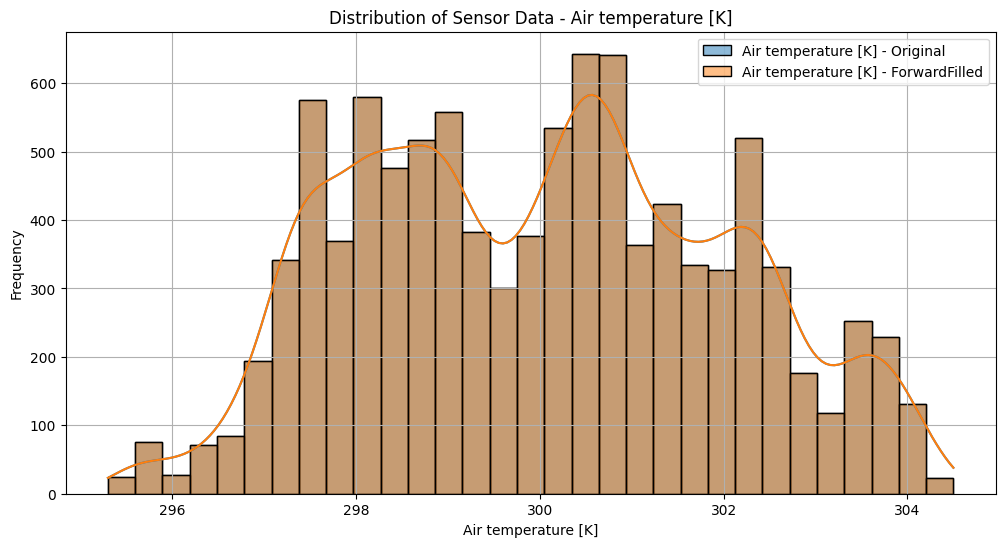

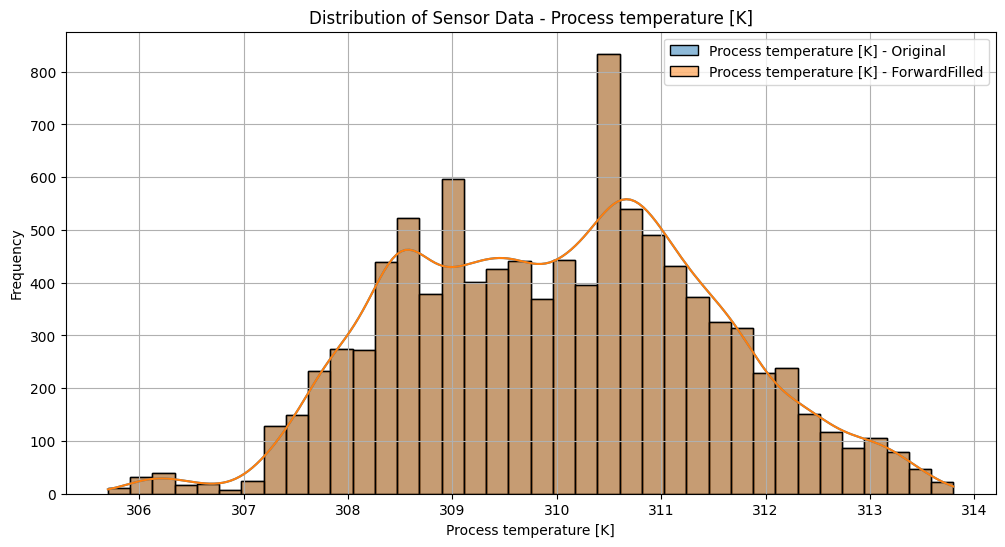

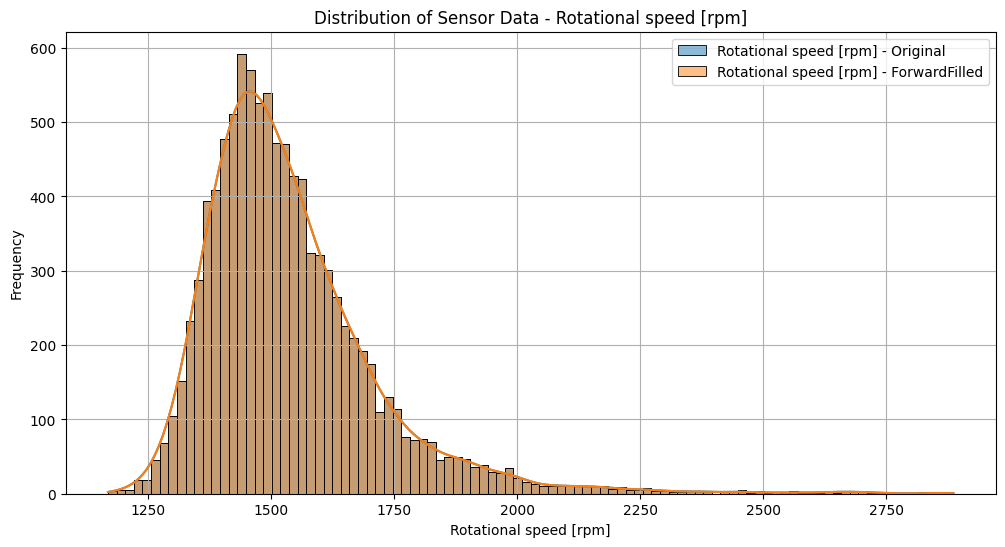

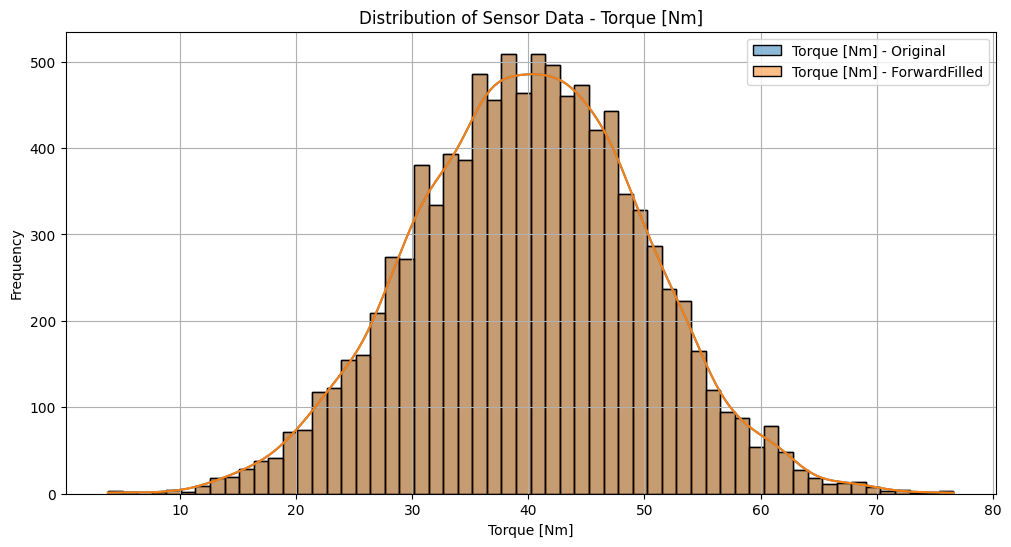

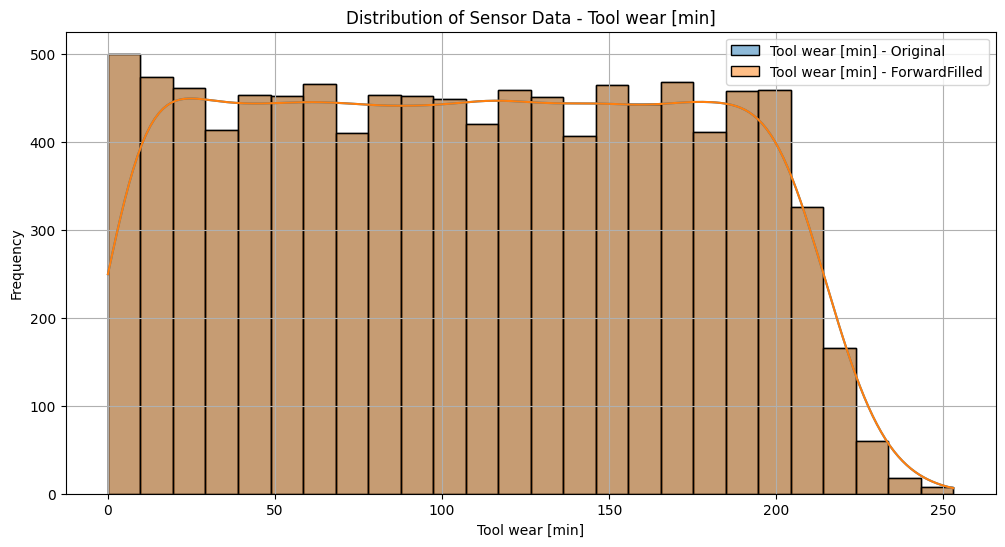

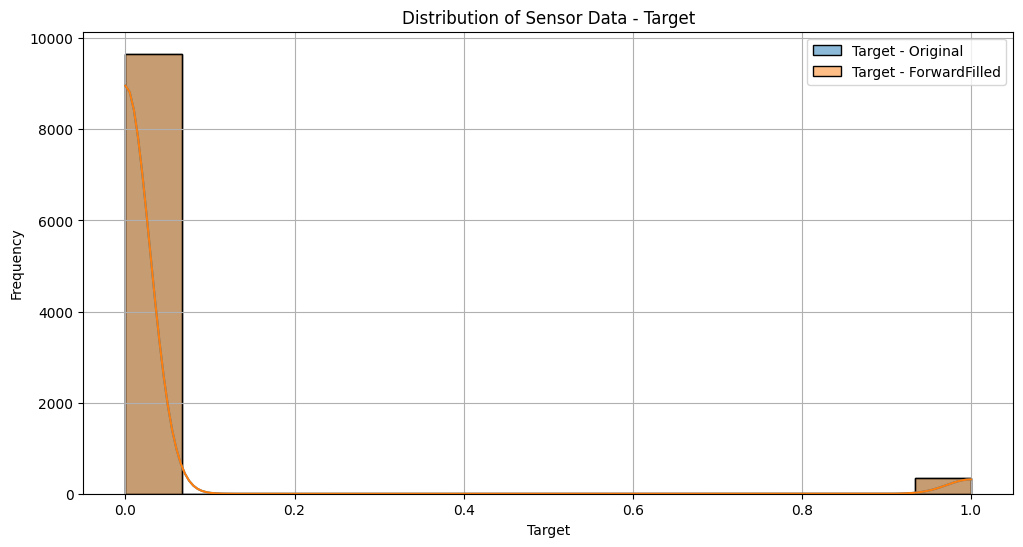

In [13]:
## Plot distribution of sensor values
for column in features:
    try:
        # Create a new figure with specified figure size for each plot
        fig, ax = plt.subplots(figsize=(12, 6))

        # Plot the data for the current sensor column on its own axis
        sns.histplot(data=pandasDf, x=column, ax=ax, kde=True, legend=True, label=f"{column} - Original")
        sns.histplot(data=pandasDfFwFilled, x=column, ax=ax, kde=True, legend=True, label=f"{column} - ForwardFilled")

        # Add grid, legend, and labels for the current plot
        ax.grid(True)
        ax.set(title=f"Distribution of Sensor Data - {column}", xlabel=column, ylabel="Frequency")
        ax.legend()
        # Show the plot in a separate window
        plt.show()
    except Exception as e:
        print(f"Error plotting {column}: {e}")

In [14]:
pandasDfFwFilled.describe()

Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
count         10000.000000             10000.000000            10000.000000   
mean            300.004930               310.005560             1538.776100   
std               2.000259                 1.483734              179.284096   
min             295.300000               305.700000             1168.000000   
25%             298.300000               308.800000             1423.000000   
50%             300.100000               310.100000             1503.000000   
75%             301.500000               311.100000             1612.000000   
max             304.500000               313.800000             2886.000000   

        Torque [Nm]  Tool wear [min]        Target  
count  10000.000000     10000.000000  10000.000000  
mean      39.986910       107.951000      0.033900  
std        9.968934        63.654147      0.180981  
min        3.800000         0.000000      0.000000  
25%       33.200000        53.000000      0.000000  
50%       40.100000       108.000000      0.000000  
75%       46.800000       162.000000      0.000000  
max       76.600000       253.000000      1.000000

In [15]:
pca = PCA(n_components=len(features))
X_pca = pd.DataFrame(data=pca.fit_transform(pandasDfFwFilled[features]), columns=['PC'+str(i+1) for i in range(len(features))])
var_exp = pd.Series(data=100*pca.explained_variance_ratio_, index=['PC'+str(i+1) for i in range(len(features))])
print('Explained variance ratio per component:', round(var_exp,2), sep='\n')
print('Explained variance ratio with 5 components: '+str(round(var_exp.values[:5].sum(),2)))

Explained variance ratio per component:
PC1    88.76
PC2    11.16
PC3     0.06
PC4     0.02
PC5     0.00
PC6     0.00
dtype: float64
Explained variance ratio with 5 components: 100.0


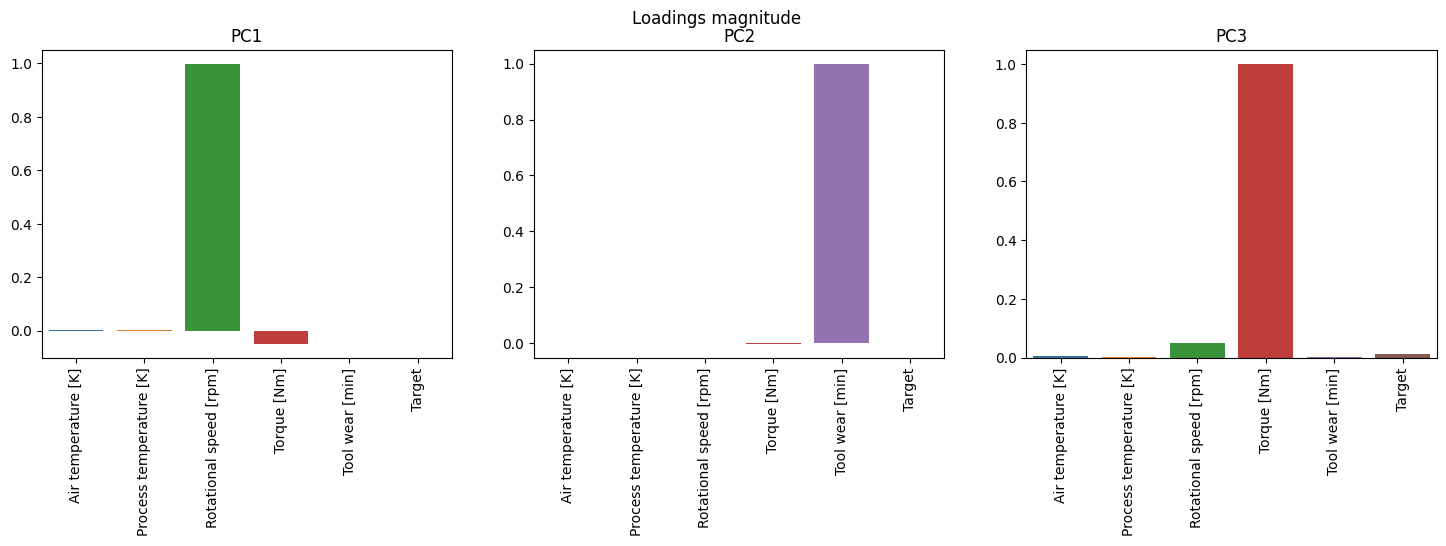

In [16]:
# PCA for Data visualization
pca3 = PCA(n_components=3)
X_pca3 = pd.DataFrame(data=pca3.fit_transform(pandasDfFwFilled[features]), columns=['PC1','PC2','PC3'])

# Loadings Analysis
fig, axs = plt.subplots(ncols=3, figsize=(18,4))
fig.suptitle('Loadings magnitude')
pca_loadings = pd.DataFrame(data=pca3.components_, columns=features)
for j in range(3):
    ax = axs[j]
    sns.barplot(ax=ax, x=pca_loadings.columns, y=pca_loadings.values[j])
    ax.tick_params(axis='x', rotation=90)
    ax.title.set_text('PC'+str(j+1))
plt.show()

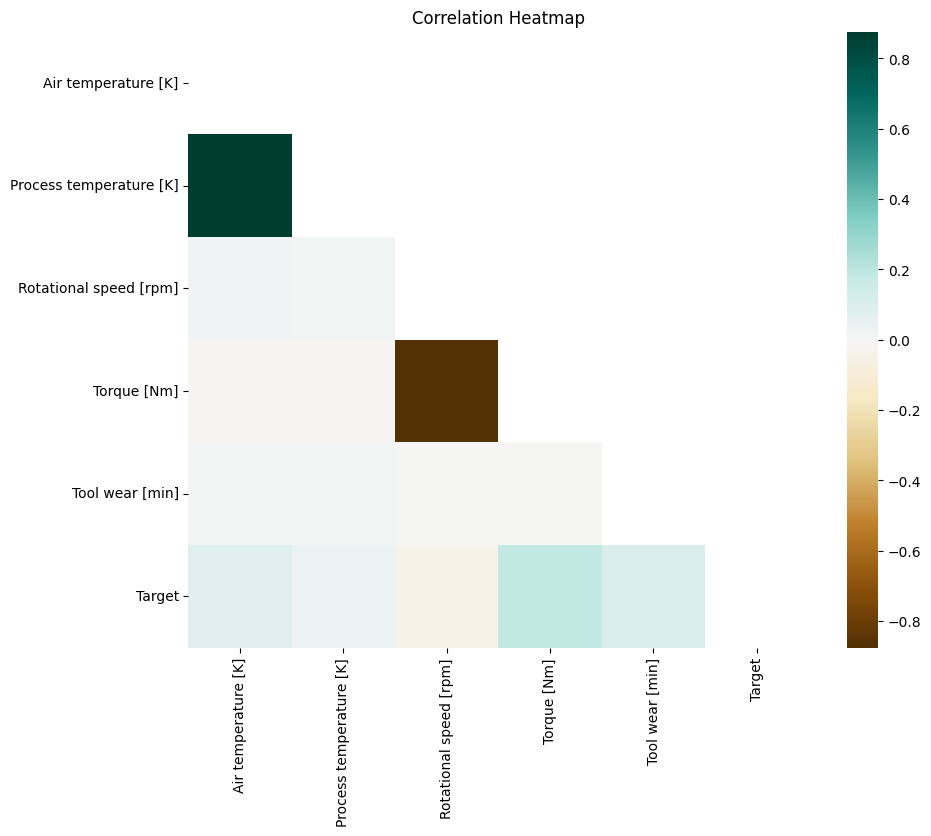

In [17]:
# Correlation Heatmap
plt.figure(figsize=(10,8))
filtered_df = pandasDfFwFilled[features]
sns.heatmap(data=filtered_df.corr(), mask=np.triu(filtered_df.corr()), annot=True, cmap='BrBG')
plt.title('Correlation Heatmap')
plt.show()

# Anomaly detection
This is built around Marco Cerliani's Anomaly Detection code, please see the original code here https://github.com/cerlymarco/MEDIUM_NoteBook/blob/master/Anomaly_Detection_Graph/Anomaly_Detection_Graph.ipynb

In [18]:
filtered_df = pandasDfFwFilled[features]
filtered_df

Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0                   298.1                    308.6                    1551   
1                   298.2                    308.7                    1408   
2                   298.1                    308.5                    1498   
3                   298.2                    308.6                    1433   
4                   298.2                    308.7                    1408   
...                   ...                      ...                     ...   
9995                298.8                    308.4                    1604   
9996                298.9                    308.4                    1632   
9997                299.0                    308.6                    1645   
9998                299.0                    308.7                    1408   
9999                299.0                    308.7                    1500   

      Torque [Nm]  Tool wear [min]  Target  
0            42.8                0       0  
1            46.3                3       0  
2            49.4                5       0  
3            39.5                7       0  
4            40.0                9       0  
...           ...              ...     ...  
9995         29.5               14       0  
9996         31.8               17       0  
9997         33.4               22       0  
9998         48.5               25       0  
9999         40.2               30       0  

[10000 rows x 6 columns]

In [19]:
corr_mat = pairwise_distances(filtered_df.T, metric='correlation')
filtered_df.shape, corr_mat.shape

((10000, 6), (6, 6))

<Axes: ylabel='Density'>

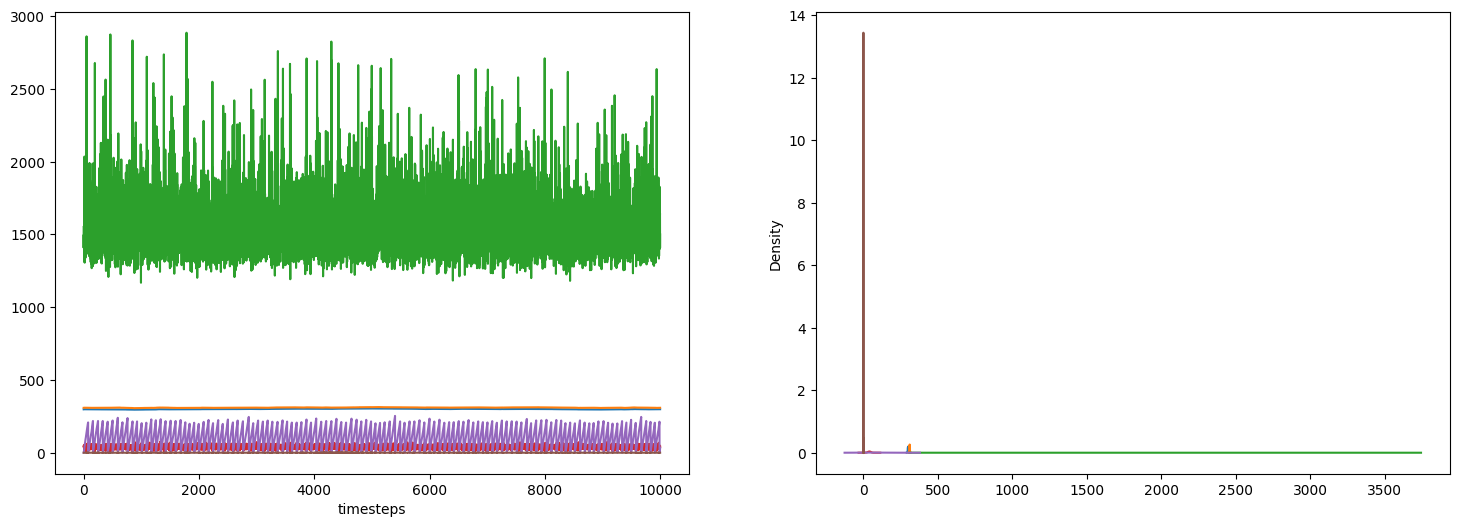

In [20]:
### PLOT SERIES DISTRIBUTIONS ###

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
filtered_df.plot(legend=False, xlabel='timesteps', ax=plt.gca())
plt.subplot(1,2,2)
filtered_df.plot(kind='density', legend=False, ax=plt.gca())

Text(0.5, 80.7222222222222, 'series')

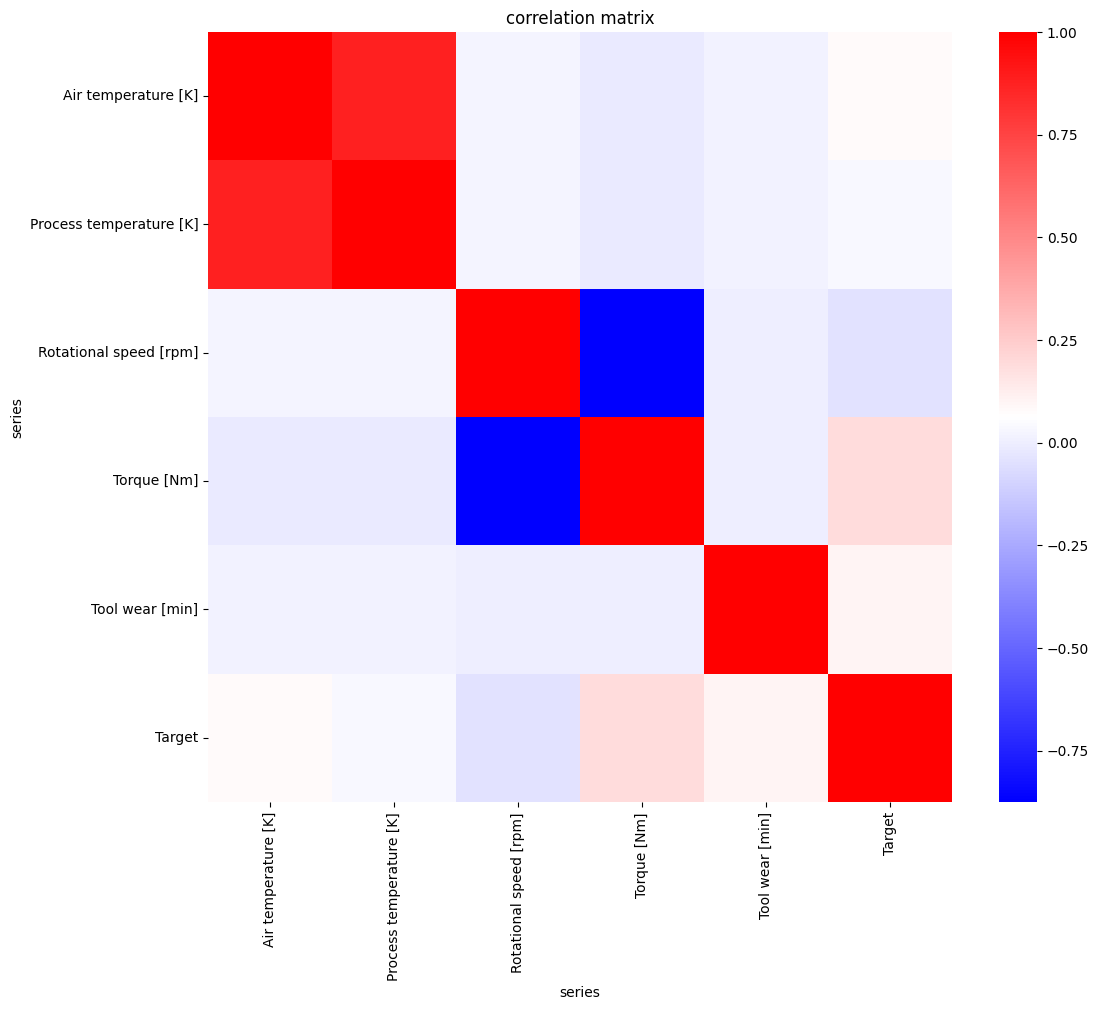

In [21]:
### PLOT SERIES CORRELATIONS ###

plt.figure(figsize=(12, 10))
sns.heatmap(filtered_df.corr(), annot=False, cmap='bwr')
plt.title('correlation matrix')
plt.ylabel('series'); plt.xlabel('series')

In [22]:
### PCA ANOMALY DETECTION ###

rec_errors_samples = {}
rec_errors_features = {}

for i, (past_id,future_id) in enumerate(
    TimeSeriesSplit(10, test_size=300).split(filtered_df)
):
    
    scaler = StandardScaler()
    pca = PCA(0.7, random_state=33)
    pca.fit(scaler.fit_transform(filtered_df.iloc[past_id]))
    
    Xt = pca.inverse_transform(
        pca.transform(
            scaler.transform(filtered_df.iloc[future_id])
        )
    )
    rec_errors_samples[past_id[-1]] = \
        np.linalg.norm(scaler.transform(filtered_df.iloc[future_id]) - Xt, axis=1)
    rec_errors_features[past_id[-1]] = \
        np.linalg.norm(scaler.transform(filtered_df.iloc[future_id]) - Xt, axis=0)

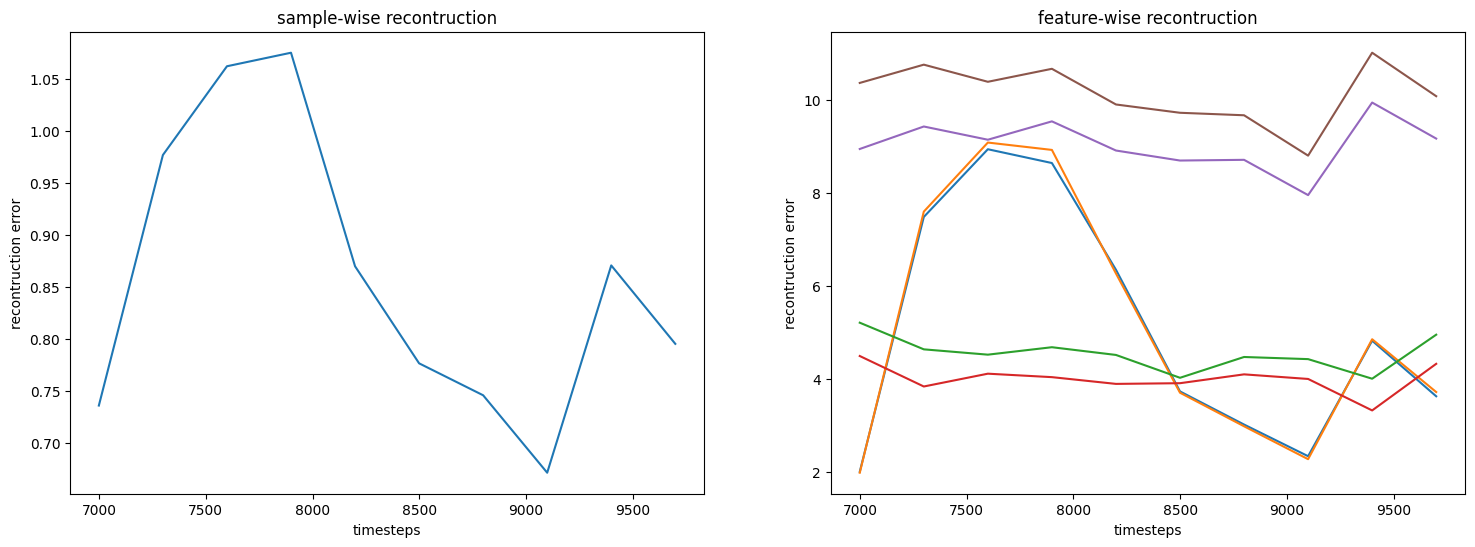

In [23]:
### PLOT PCA RECONSTRUCTION ERRORS ###

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.plot(list(rec_errors_samples.keys()), 
         [np.mean(r) for r in rec_errors_samples.values()])
plt.ylabel('recontruction error'); plt.xlabel('timesteps')
plt.title('sample-wise recontruction')

plt.subplot(1,2,2)
for i in range(len(filtered_df.columns)):
    rec = []
    for r in rec_errors_features.values():
        rec.append(r[i])
    plt.plot(list(rec_errors_features.keys()), rec)
plt.ylabel('recontruction error'); plt.xlabel('timesteps')
plt.title('feature-wise recontruction')

plt.show()

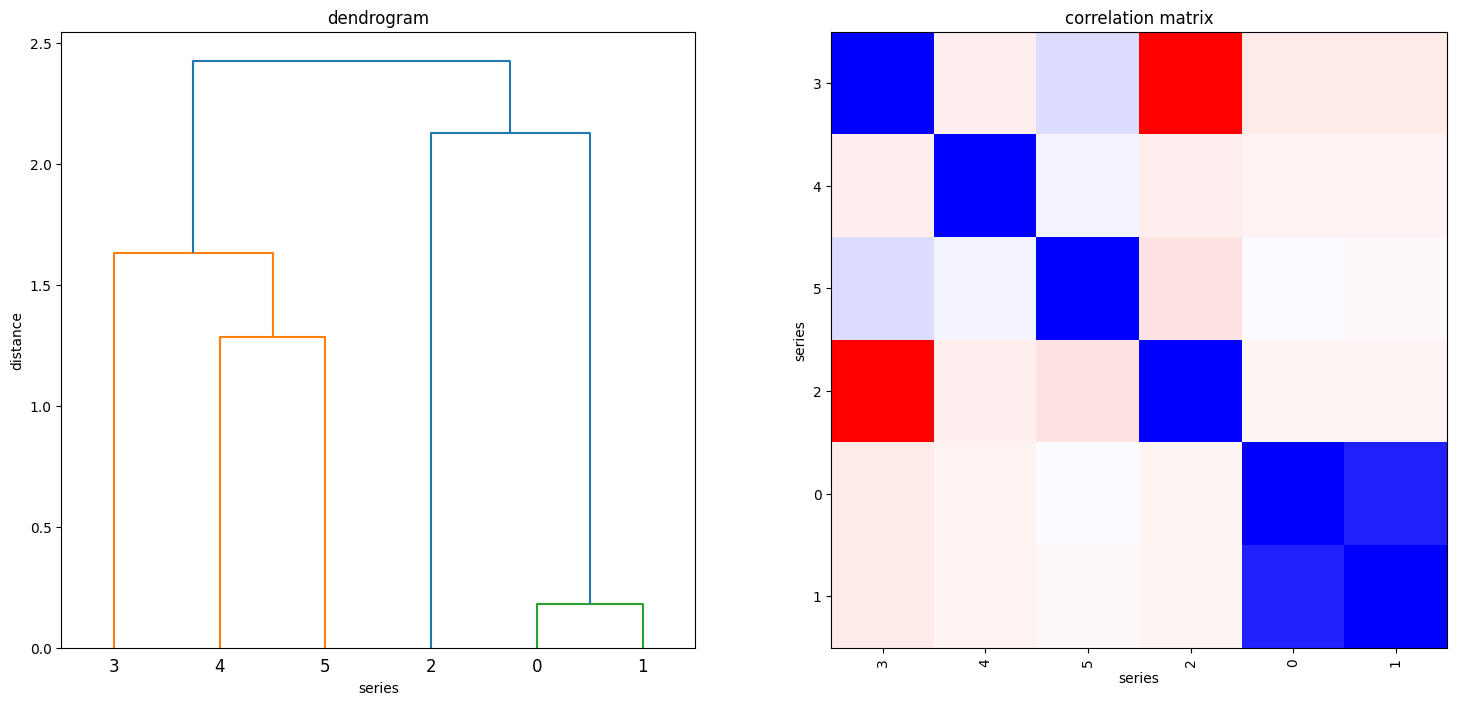

In [24]:
### COMPUTE HIERARCHICAL CLUSTERING ON CORRELATION MATRIX ###

d = sch.distance.pdist(corr_mat)
L = sch.linkage(d, method='ward')
ind = sch.fcluster(L, d.max(), 'distance')
dendrogram = sch.dendrogram(L, no_plot=True)

labels = dendrogram['leaves']
corr_mat_cluster = pairwise_distances(
    pd.concat([filtered_df.iloc[:,[i]] for i in labels], axis=1).T,
    metric='correlation'
)
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
dendrogram = sch.dendrogram(L, no_plot=False)
plt.title('dendrogram')
plt.ylabel('distance'); plt.xlabel('series')
plt.subplot(1,2,2)
plt.imshow(corr_mat_cluster, cmap='bwr')
plt.title('correlation matrix')
plt.ylabel('series'); plt.xlabel('series')
plt.xticks(range(len(features)), labels, rotation=90)
plt.yticks(range(len(features)), labels)
plt.show()

### Details
#### DBSCAN
- DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a popular clustering algorithm that is primarily used for clustering complex data sets, including those with noise and outliers. 

- Initializes the DBSCAN clustering algorithm with specific parameters:
eps=0.6: The maximum distance between two samples for them to be considered as in the same neighborhood.
min_samples=1: The number of samples in a neighborhood for a point to be considered as a core point.
metric="precomputed": Indicates that the input to DBSCAN will be a precomputed distance matrix.


#### Time Series Splitting
- This function from sklearn is used to split the time series data into training segments for the purpose of cross-validation, especially in a time-ordered dataset. Here, it generates 10 splits, each with a training set size up to 300 and a test set size exactly 300.

#### Iterative Processing
- For each split generated by TimeSeriesSplit, the following operations are performed:

##### Data Selection and Preprocessing
- fillna: Missing values in the current data slice are filled with the mean of each column.
- variances and Data Filtering: Drops columns where the variance is extremely low, assuming that very little variance means the data is almost constant and not useful for detecting patterns.

##### Correlation and Distance Matrix Computation
- corrcoef: Computes the correlation matrix for the filtered data transposed. Correlation values are clipped between -1 and 1 to avoid any computational errors.
- Conversion to Distance Matrix: The correlation matrix is transformed into a distance matrix. This converts similarity (correlation) into dissimilarity (distance).

##### DBSCAN Clustering
- fit_predict: DBSCAN is applied to the distance matrix to identify clusters. Clusters are formed based on the density of data points, with outliers being labeled as -1 (considered 'noise' in DBSCAN terminology).

##### Anomaly Detection
- The columns corresponding to clusters identified by DBSCAN (excluding noise) are considered anomalies. These anomalous features are recorded in the network_ano dictionary, keyed by the last index of the past data slice.


In [27]:
# Initialize DBSCAN
dbscan = DBSCAN(eps=0.6, min_samples=1, metric="precomputed")
network_ano = {}

# Iterate over time series splits
for i, (past_id, _) in enumerate(
    TimeSeriesSplit(10, test_size=300, max_train_size=300).split(filtered_df)):
    # Select the data for the current split
    current_data = filtered_df.iloc[past_id]

    # Fill NaNs with the mean of each column
    current_data_filled = current_data.fillna(current_data.mean())

    # Drop constant columns more rigorously
    variances = current_data_filled.var()
    current_data_filtered = current_data_filled.loc[:, variances > 1e-8]  # Adjust threshold as needed

    # Compute the correlation matrix
    correlation_matrix = np.corrcoef(current_data_filtered.T)
    np.clip(correlation_matrix, -1, 1, out=correlation_matrix)  # Clip values just in case

    # Check and handle NaNs in the correlation matrix
    if np.isnan(correlation_matrix).any():
        np.nan_to_num(correlation_matrix, copy=False, nan=0.0)

    # Convert correlation matrix to a distance matrix
    dist_matrix = 1 - correlation_matrix

    # Fit DBSCAN and predict
    preds = dbscan.fit_predict(dist_matrix)

    # Pickle the DBSCAN model and store it
    with open(f'../models/unsupervised_dbscan_model_{i}.pkl', 'wb') as file:
        pickle.dump(dbscan, file)

    # Check for anomalies (clusters other than -1, which is the label for 'noise')
    if (preds > 0).any():
        ano_features = list(current_data_filtered.columns[np.where(preds > 0)[0]])
        network_ano[past_id[-1]] = ano_features
    else:
        network_ano[past_id[-1]] = None

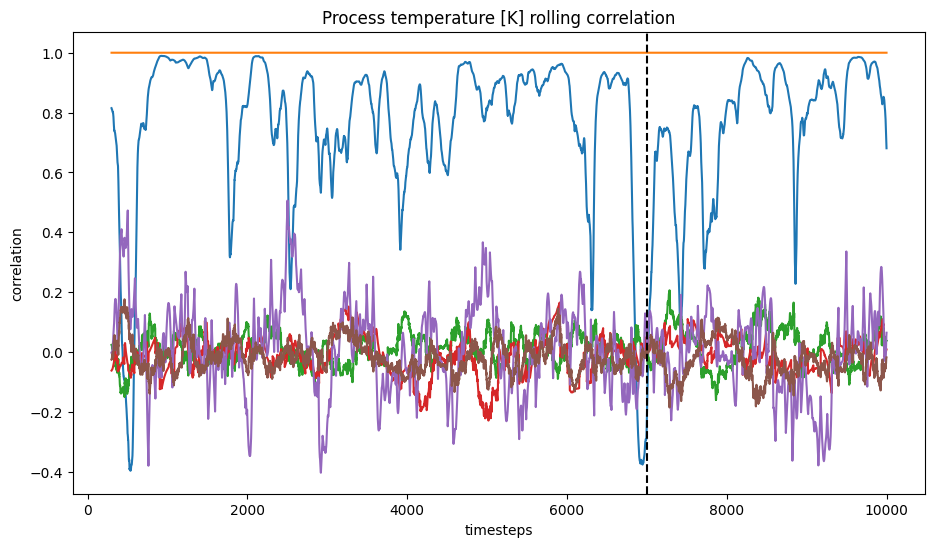

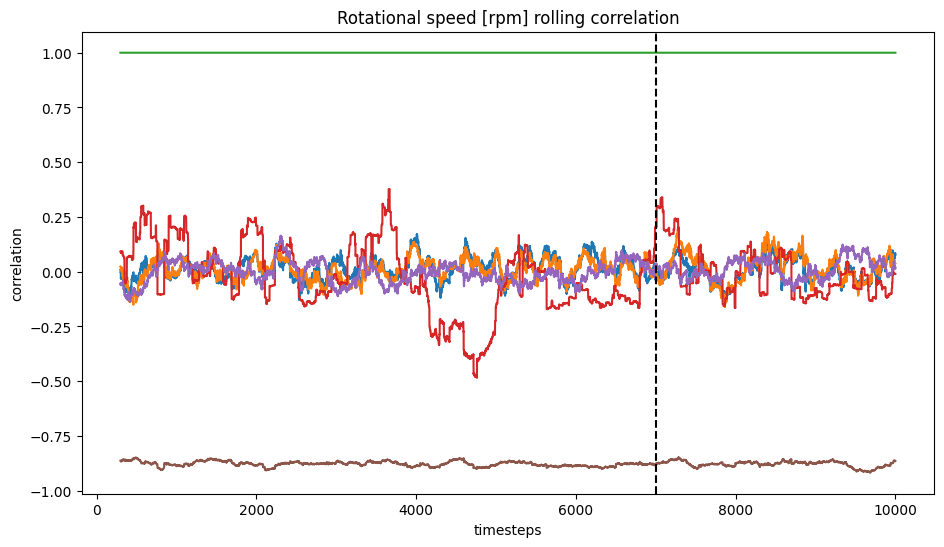

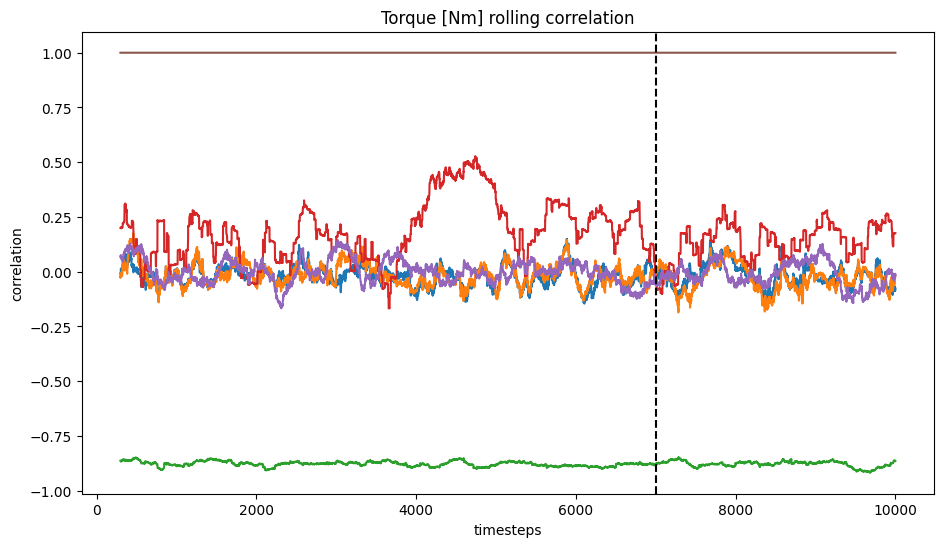

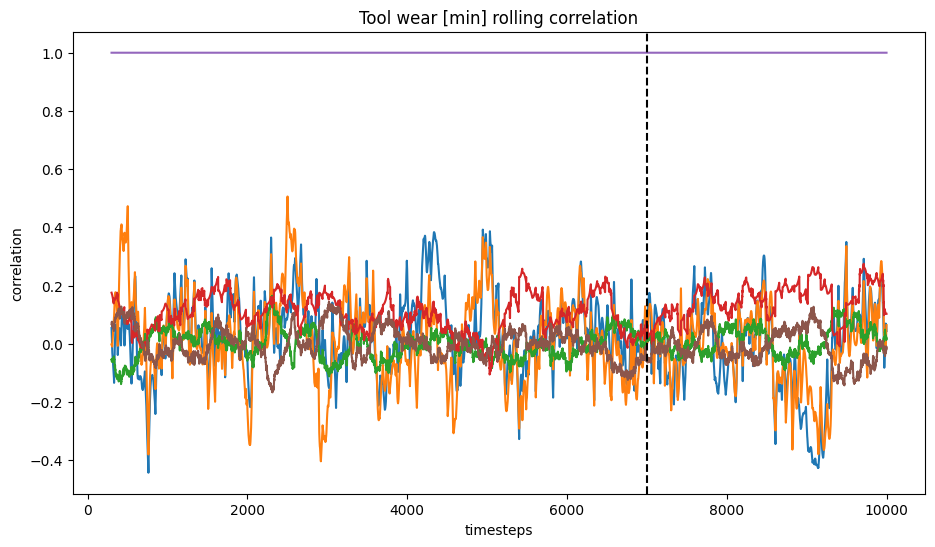

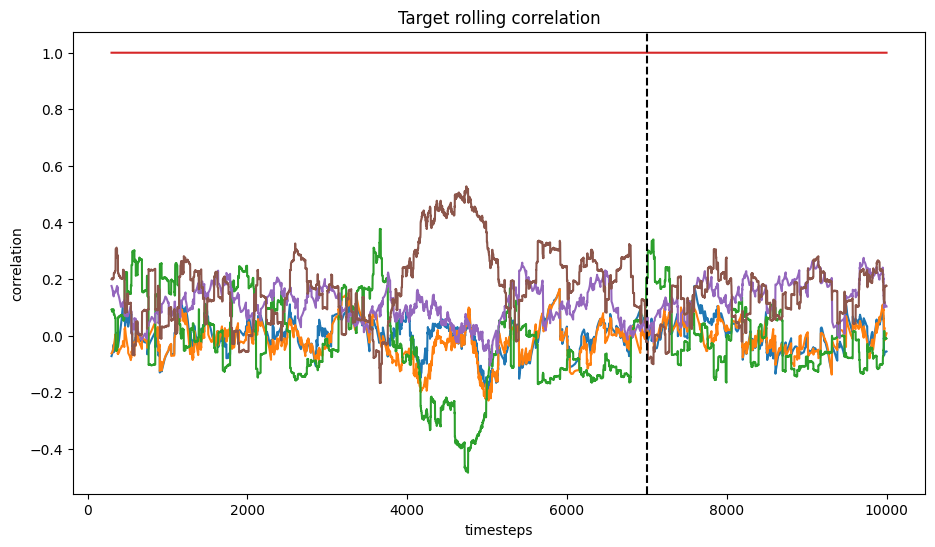

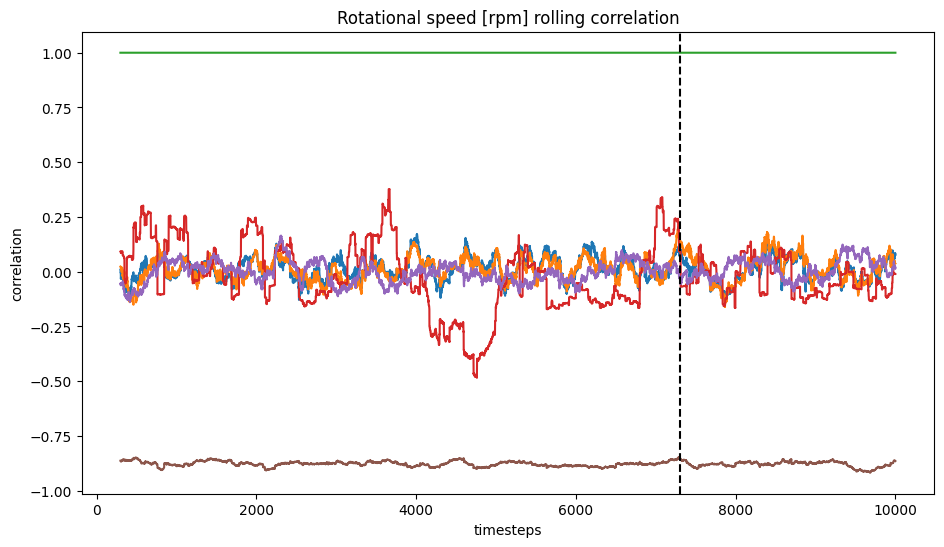

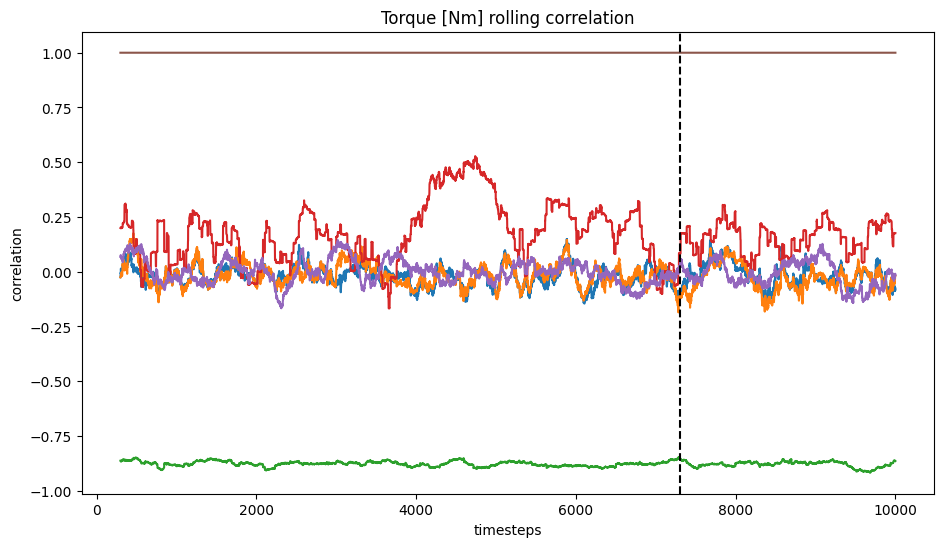

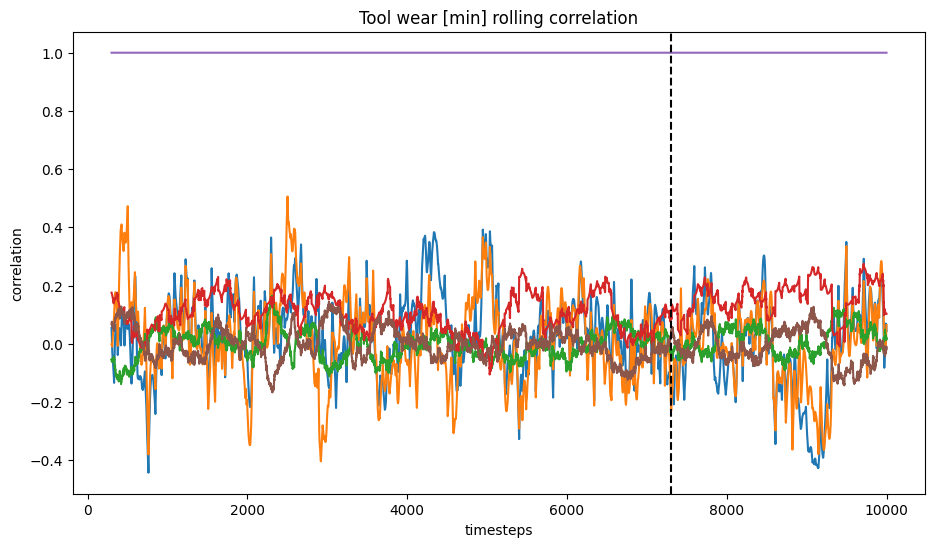

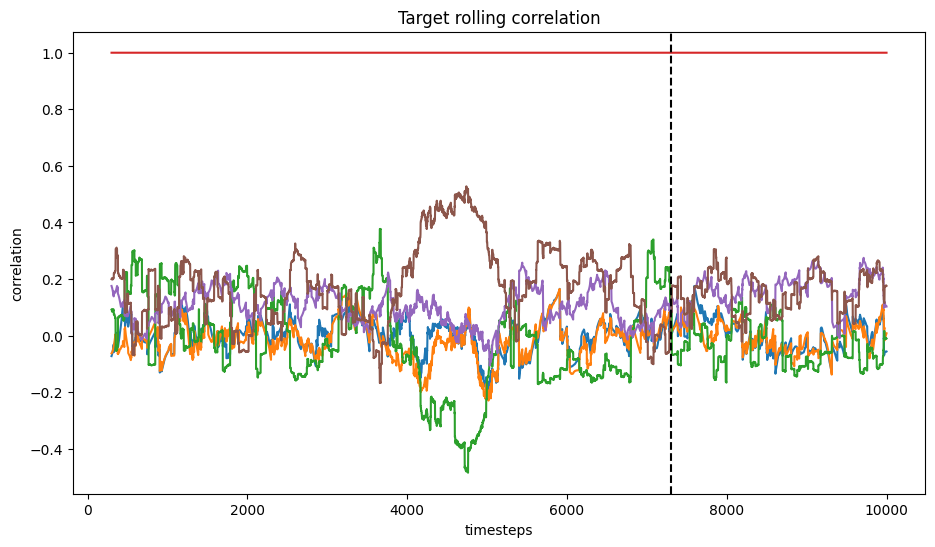

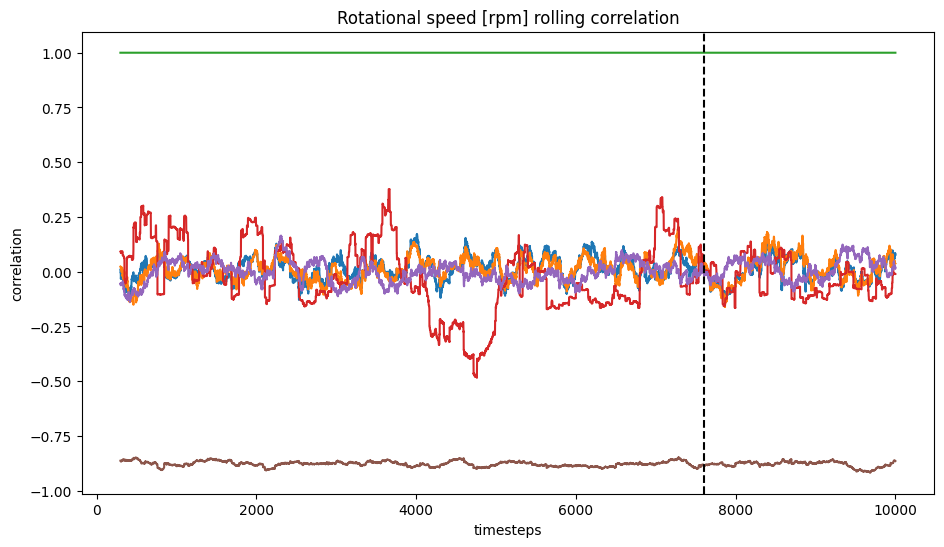

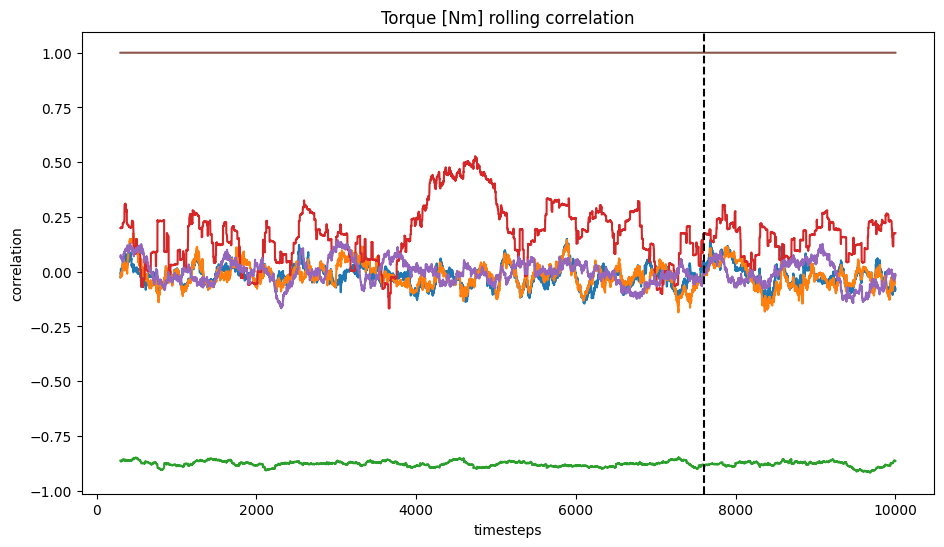

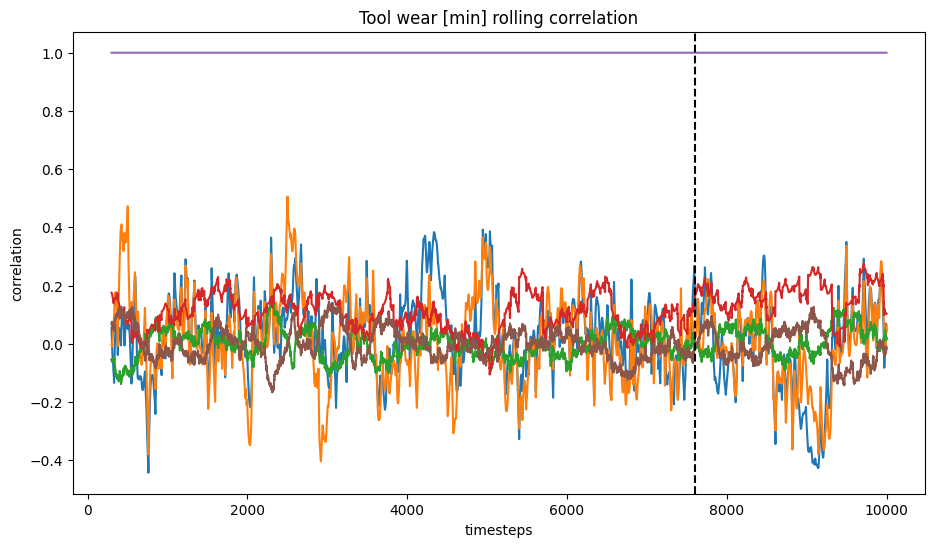

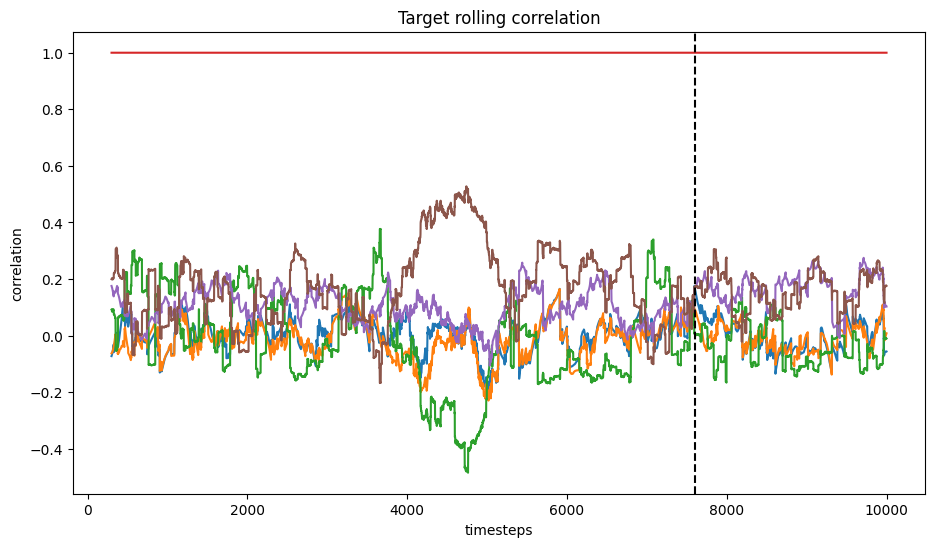

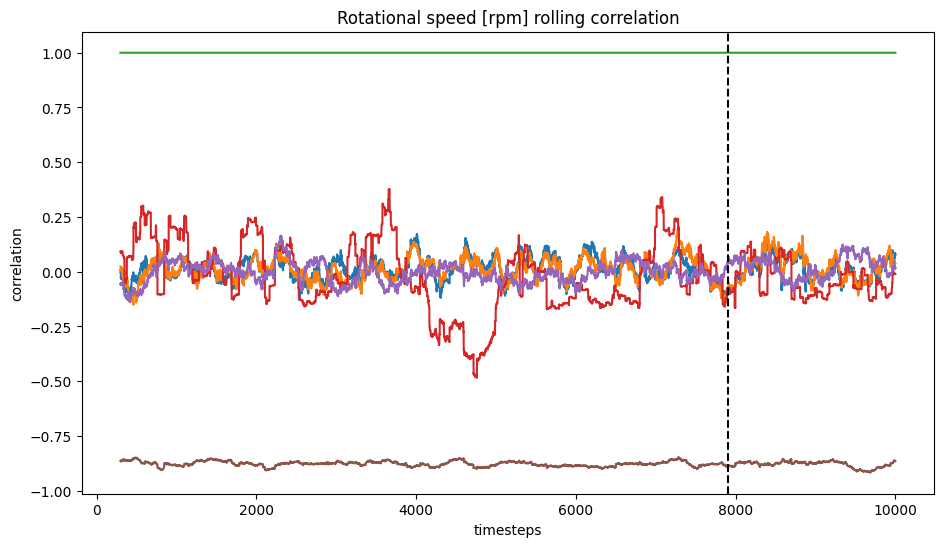

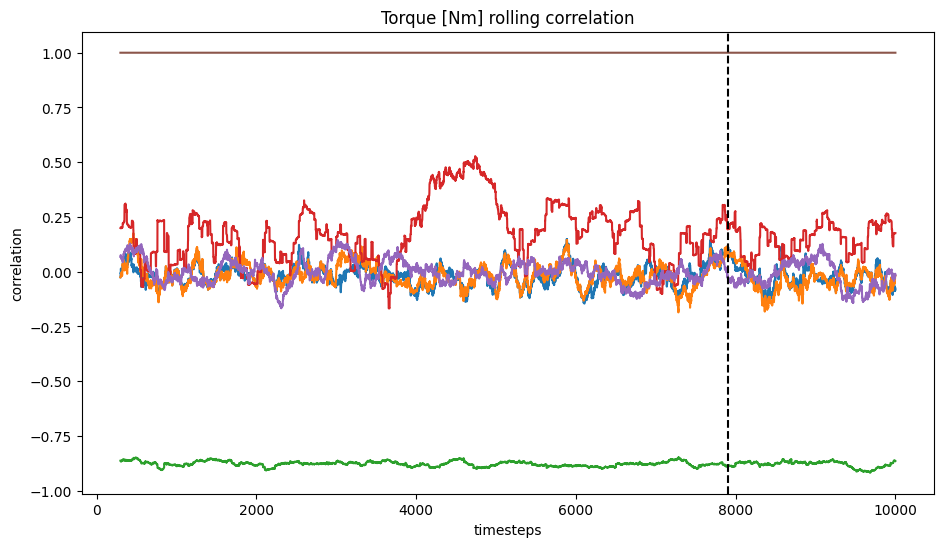

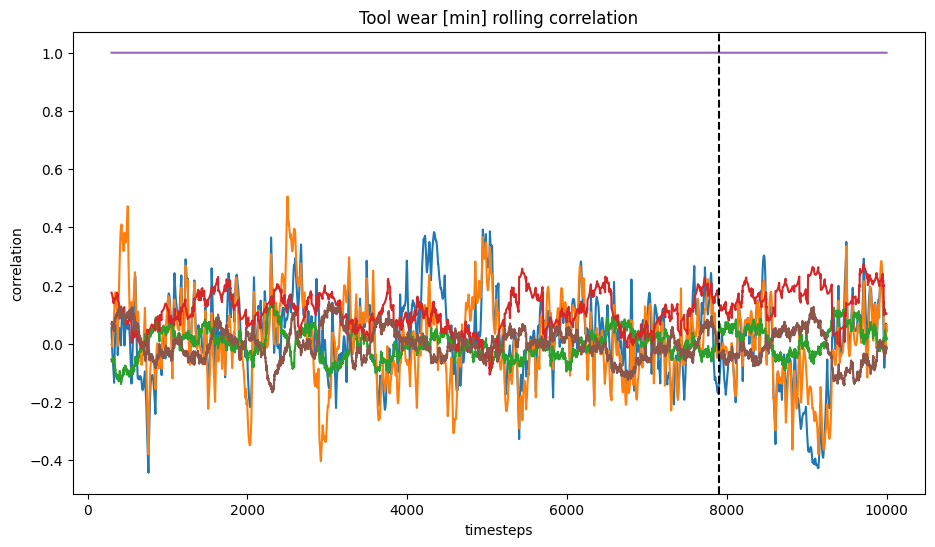

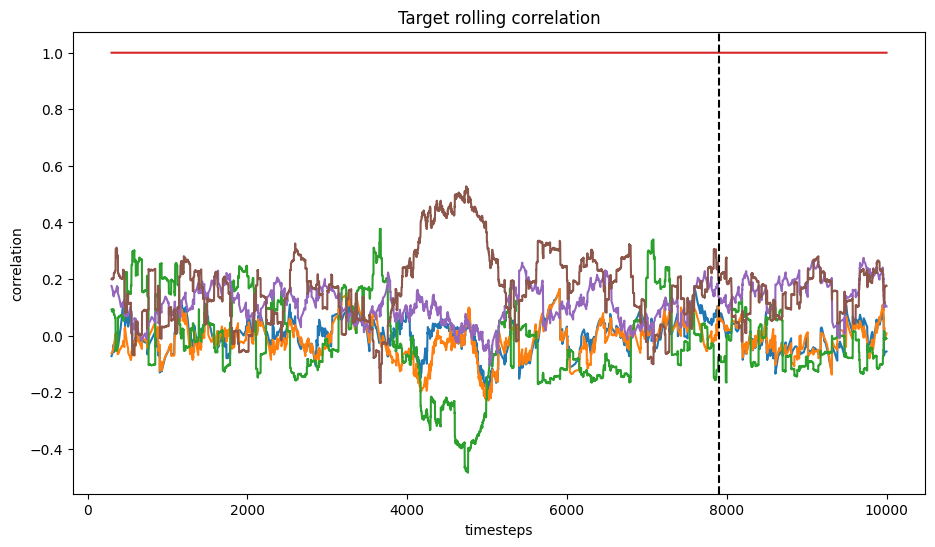

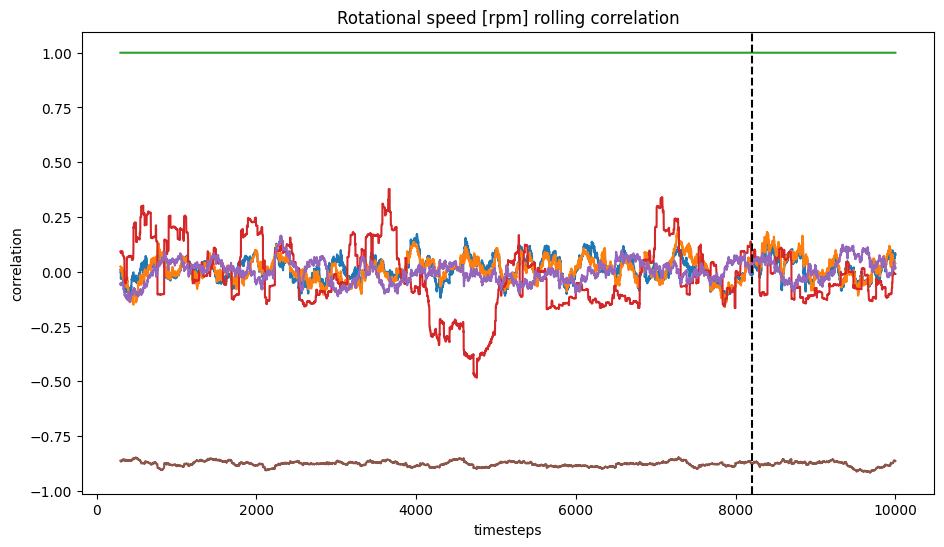

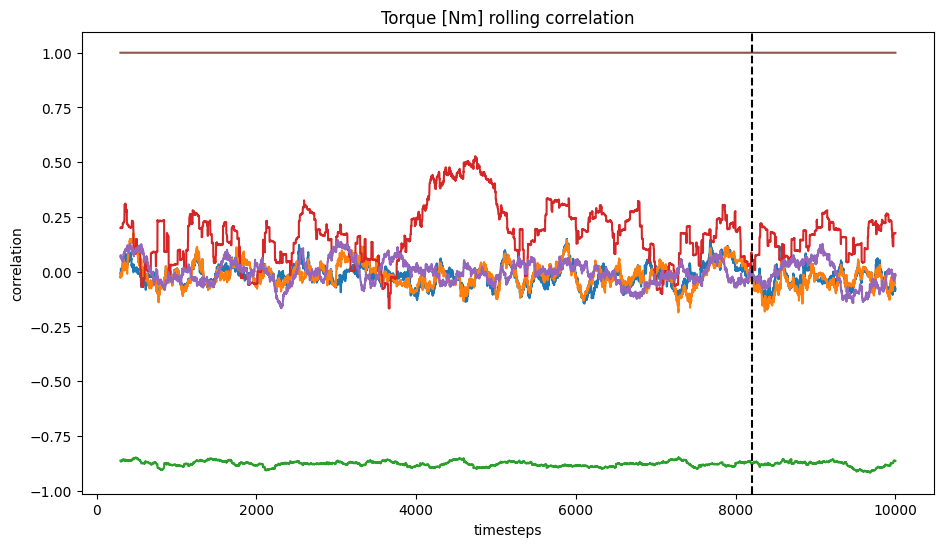

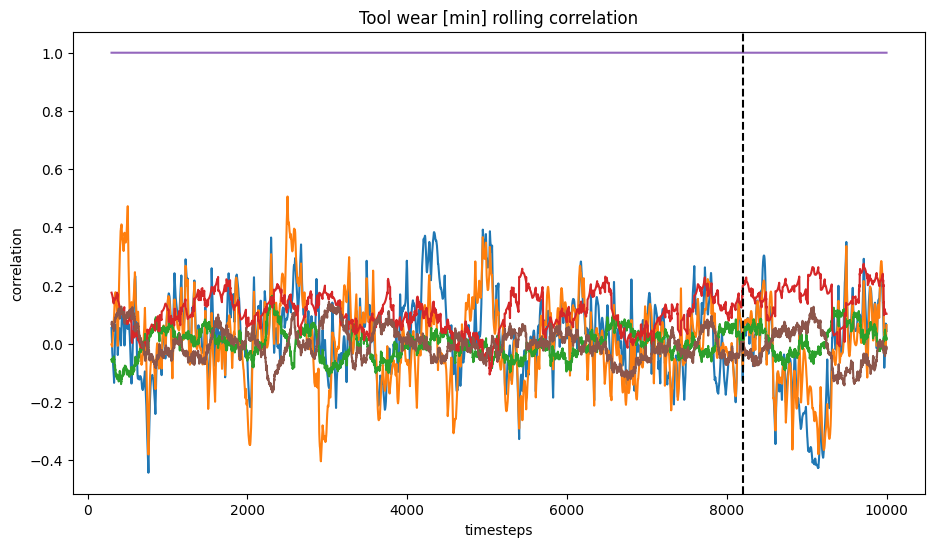

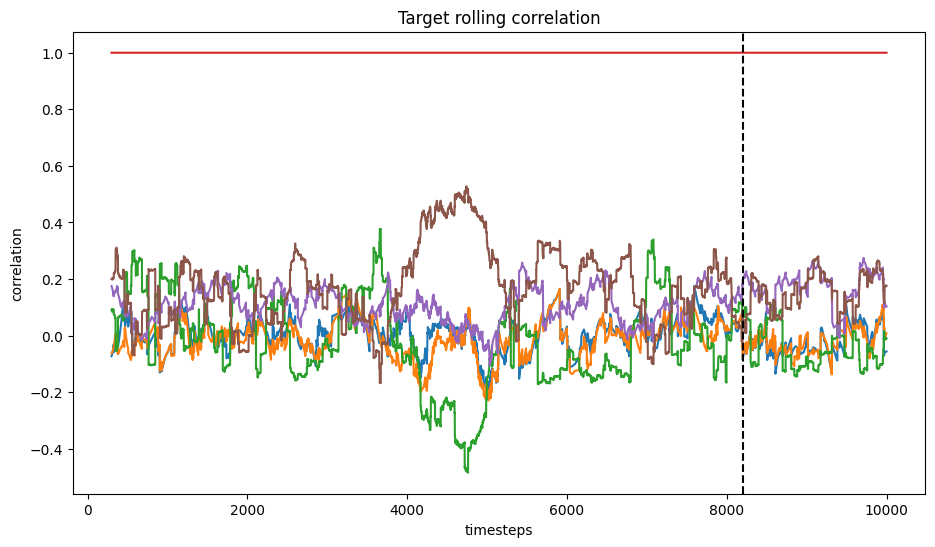

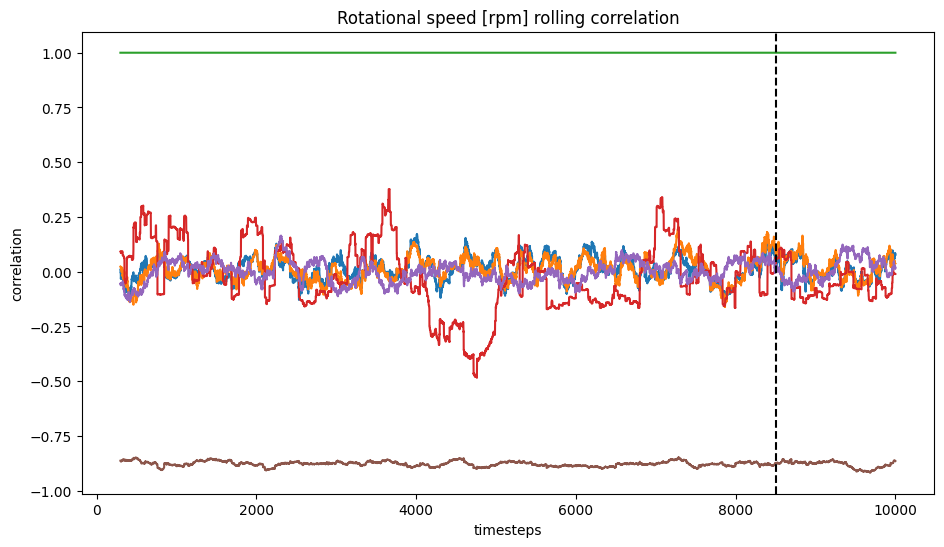

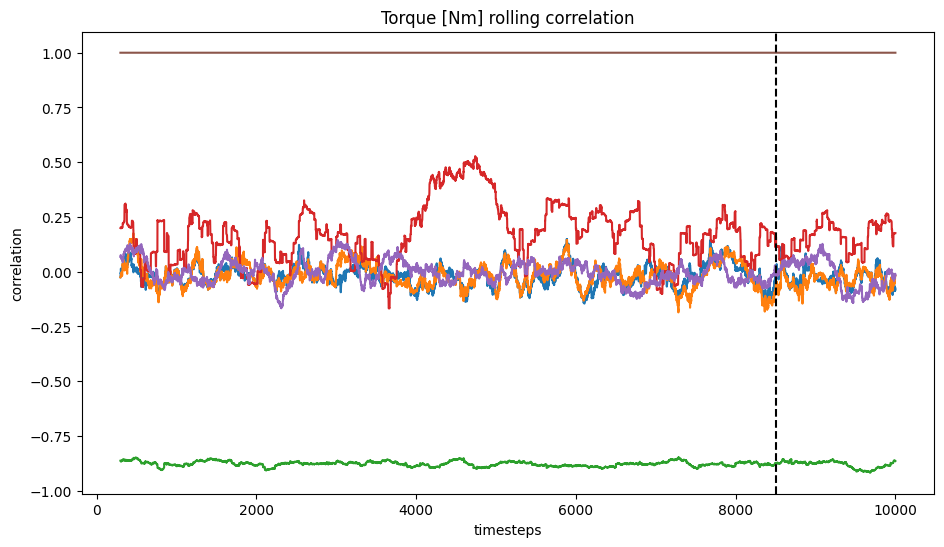

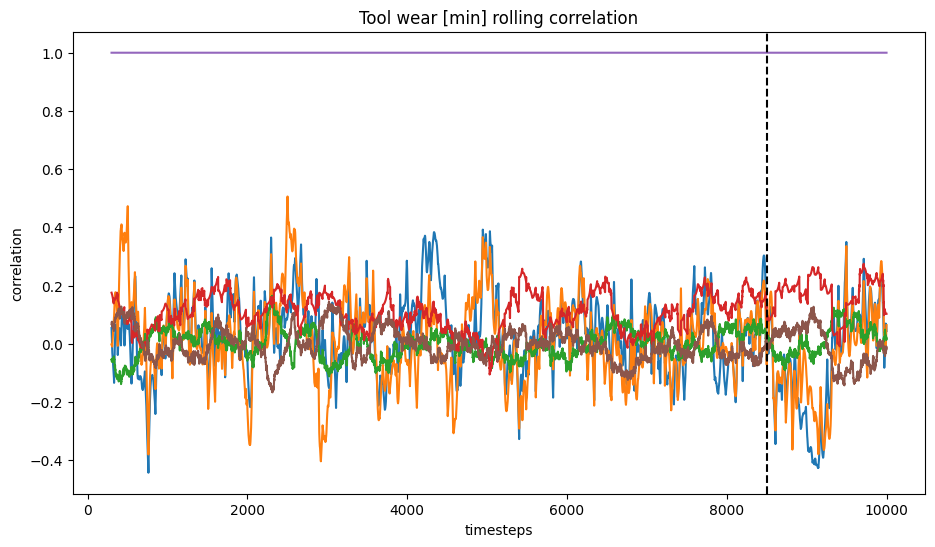

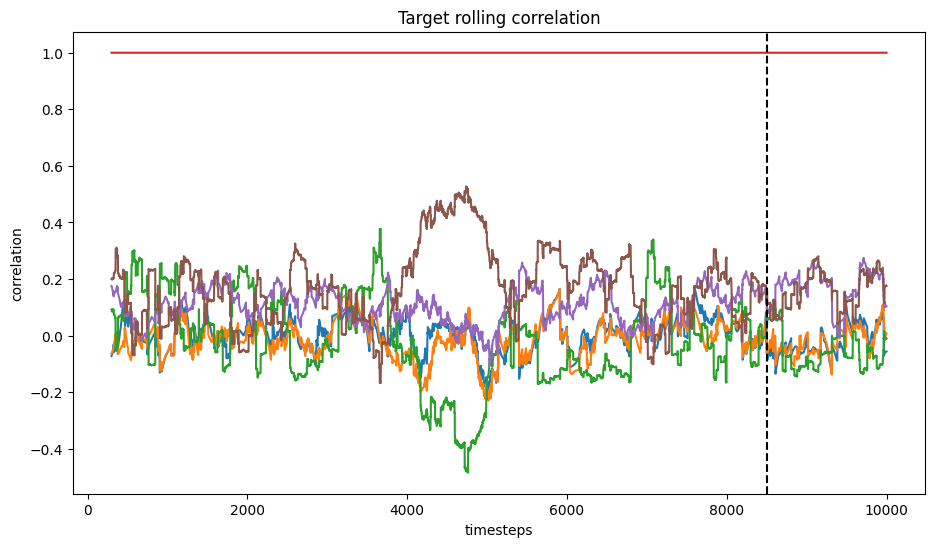

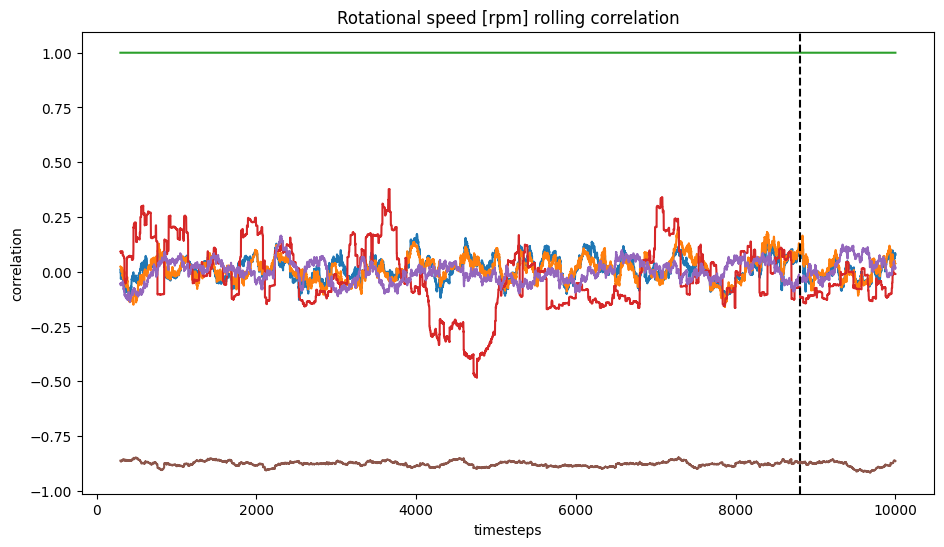

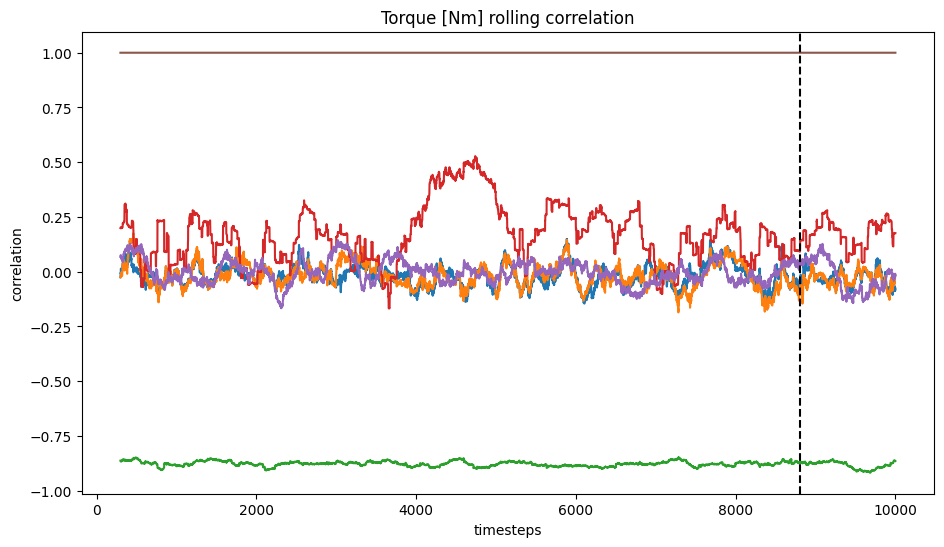

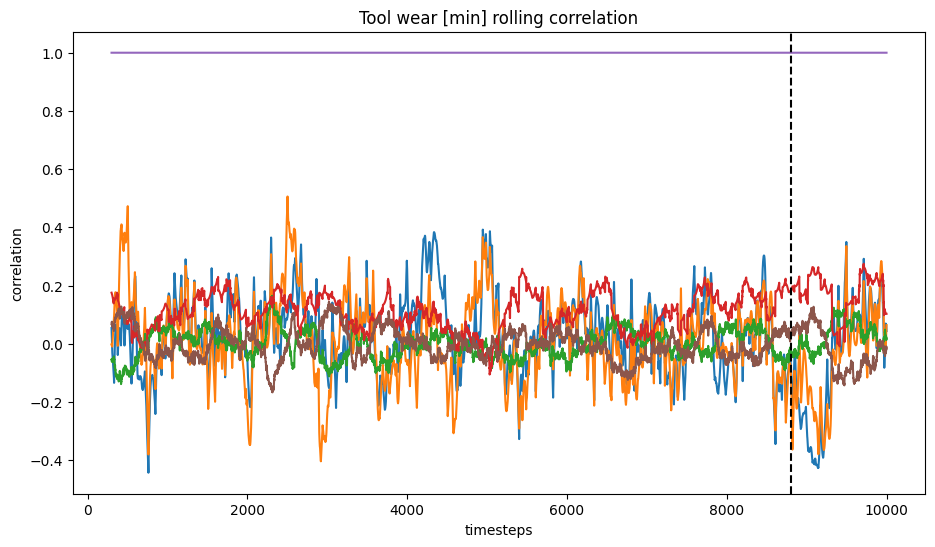

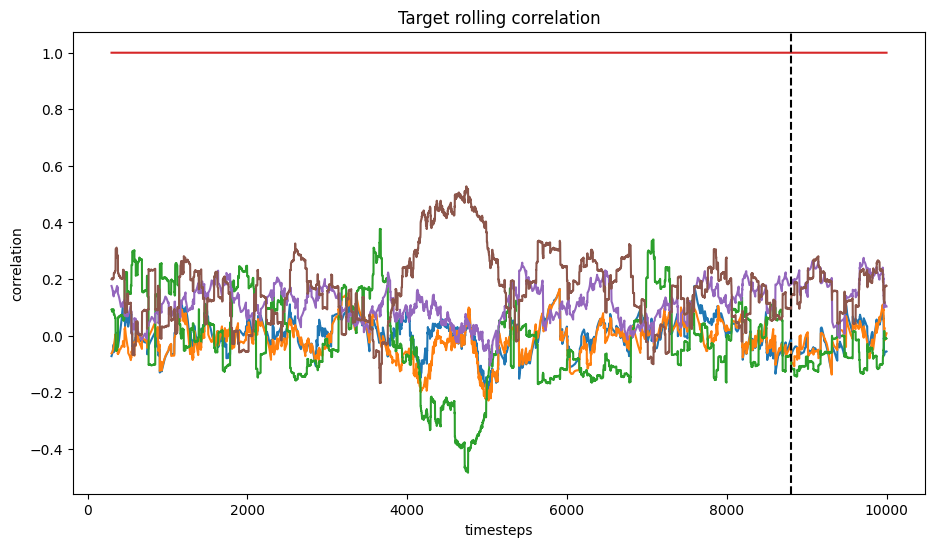

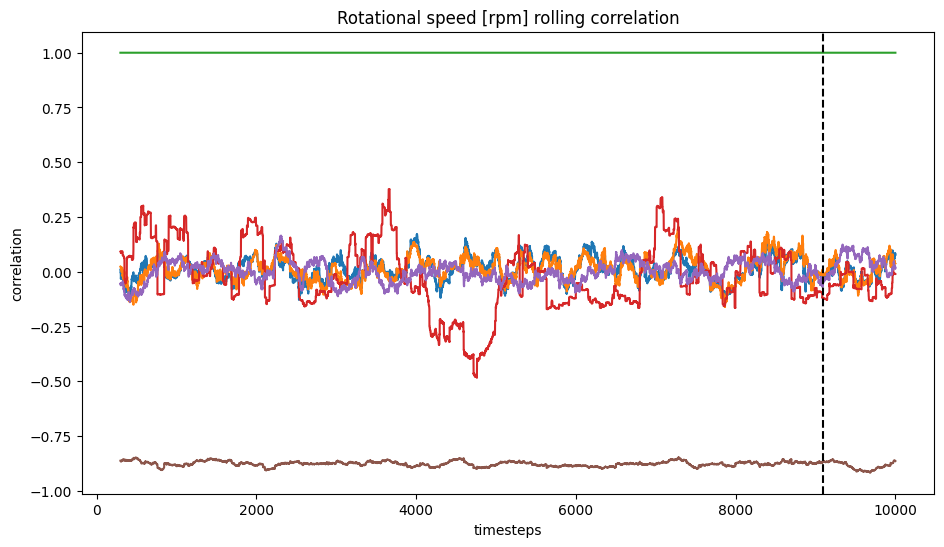

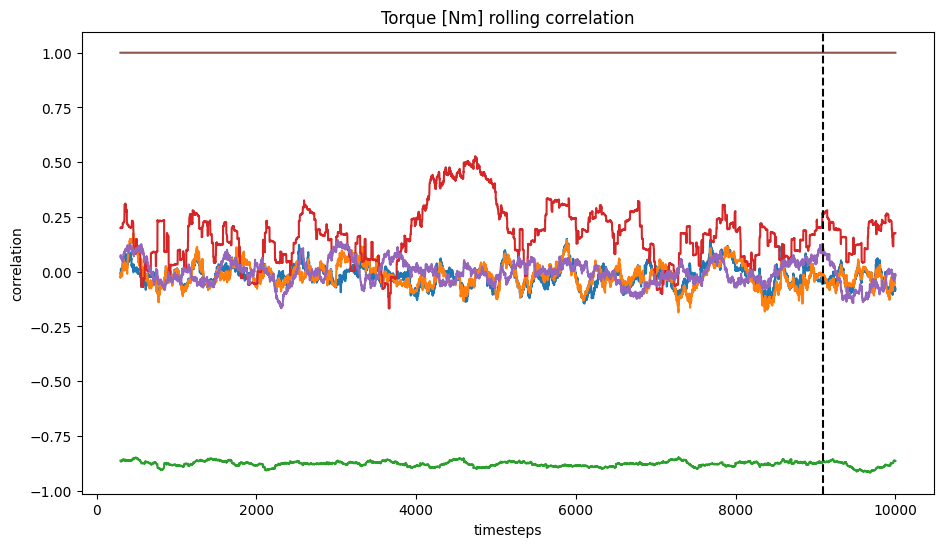

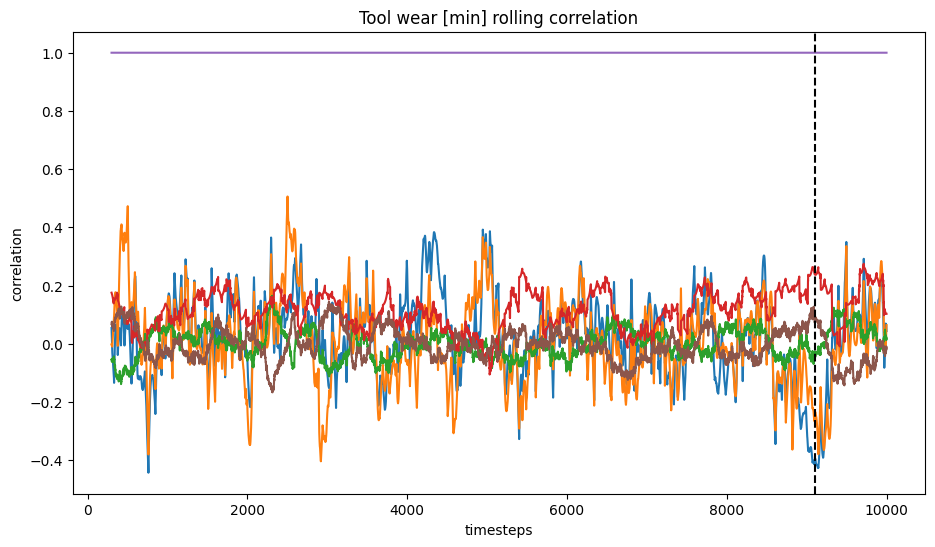

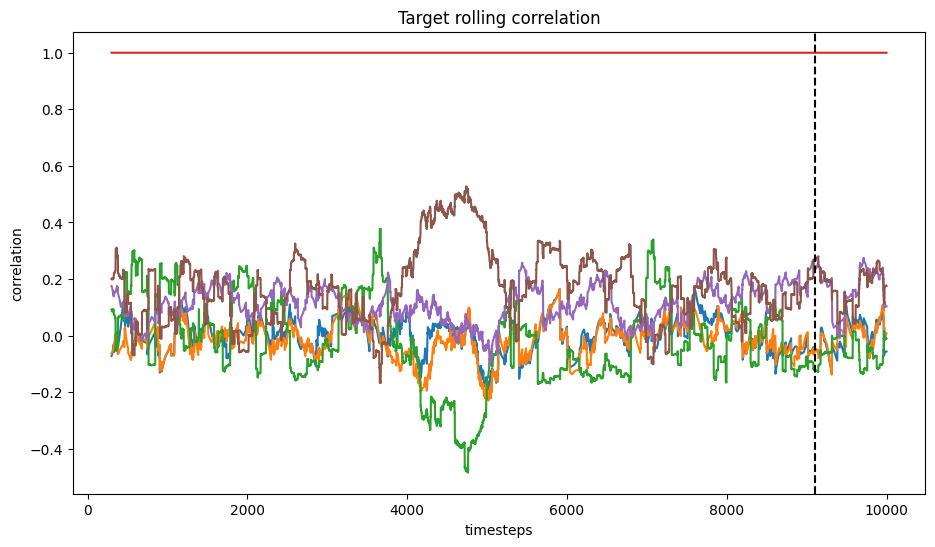

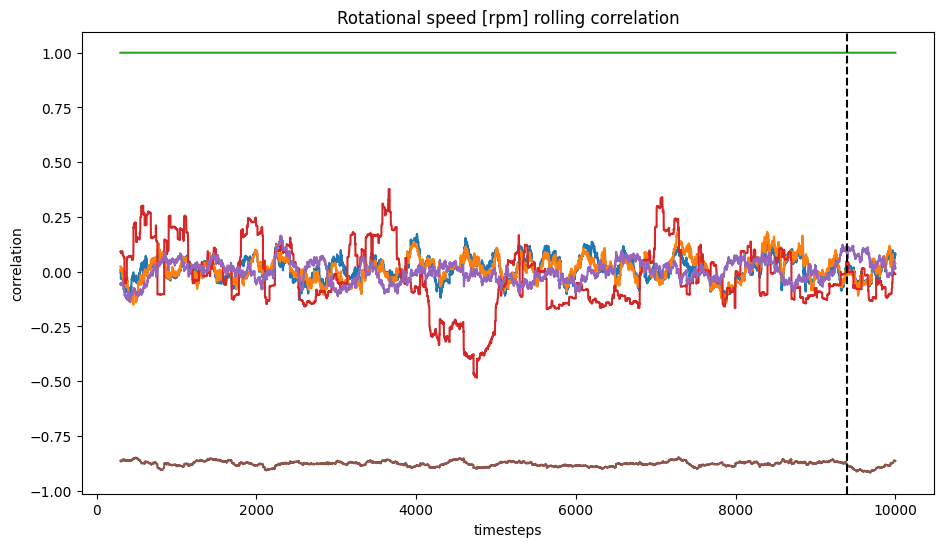

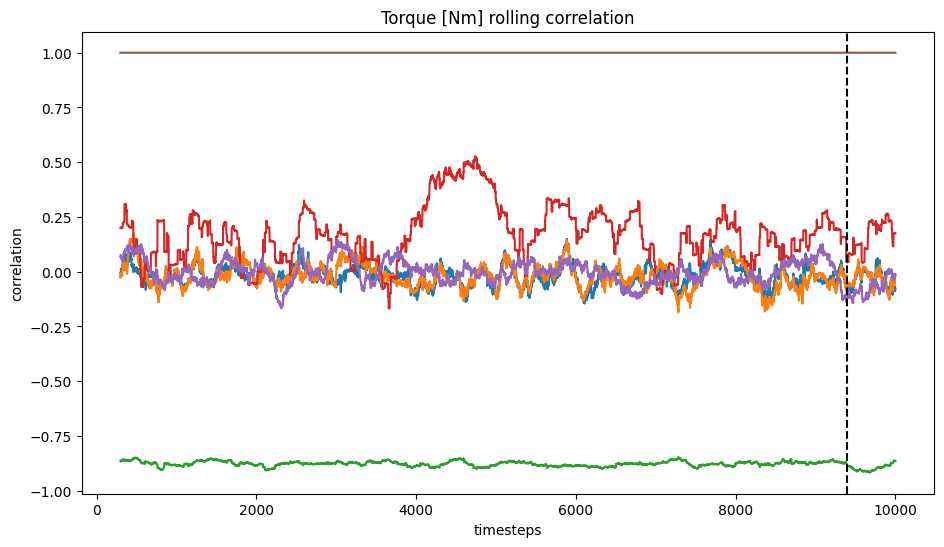

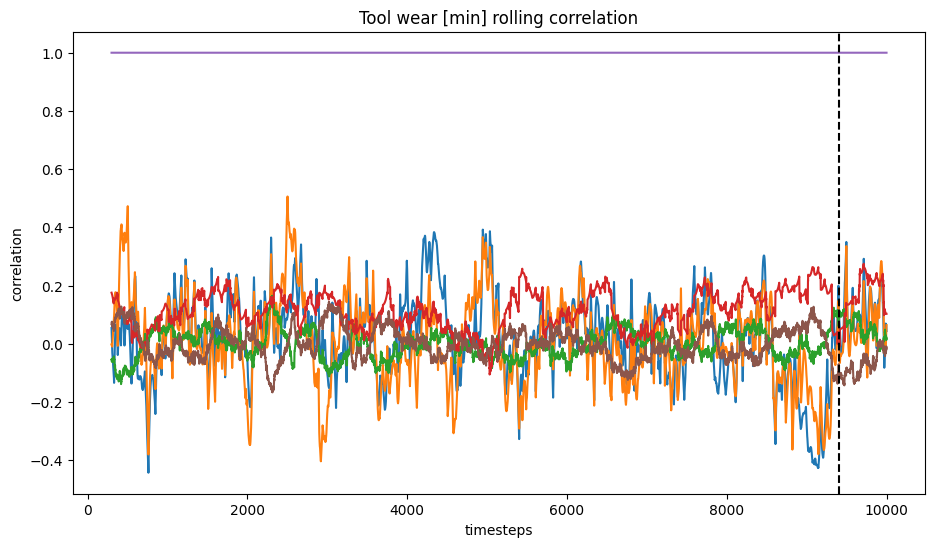

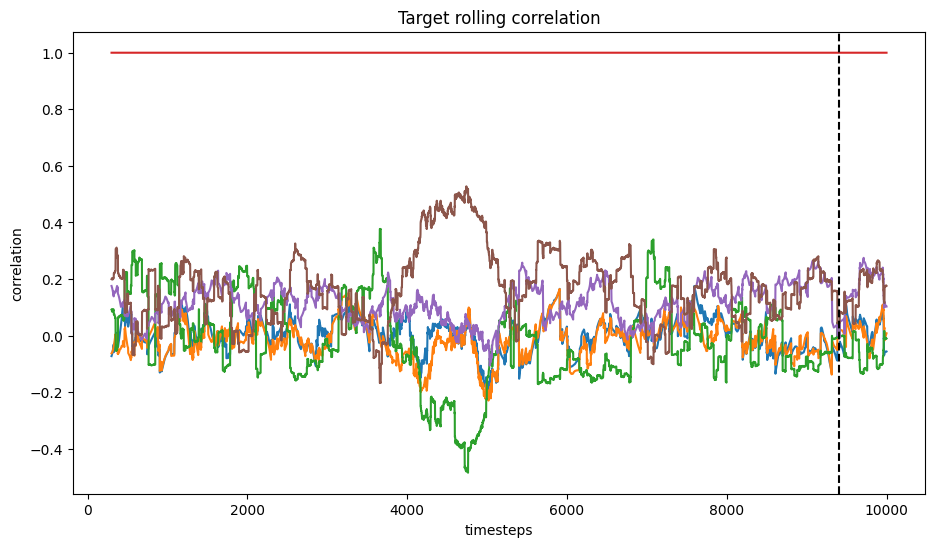

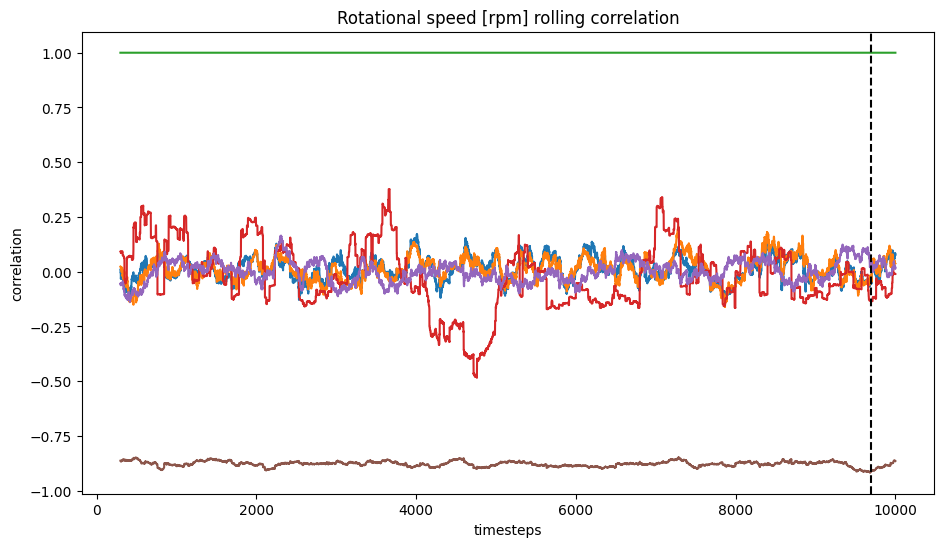

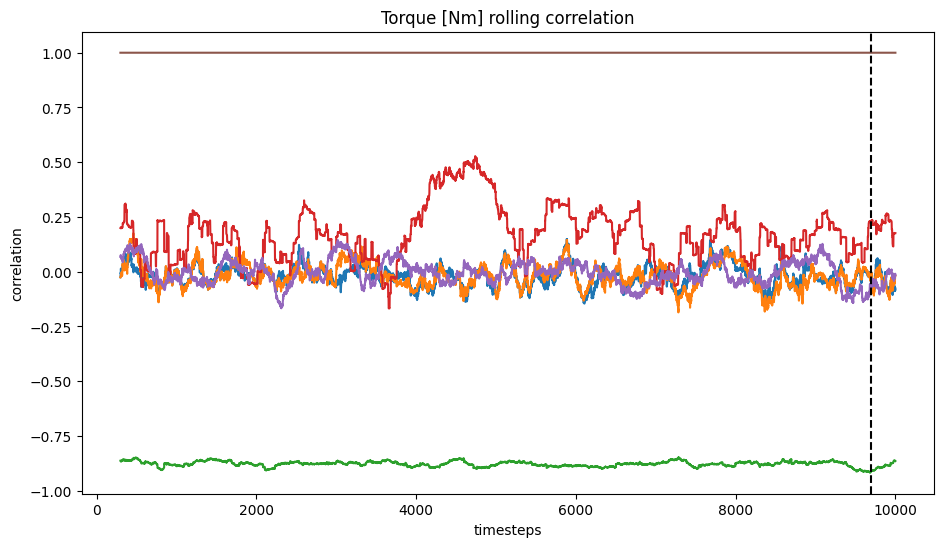

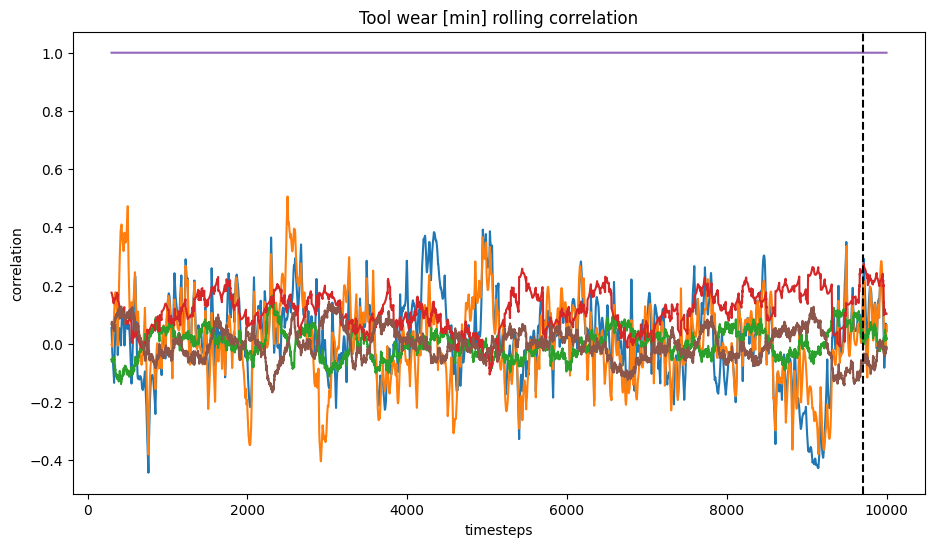

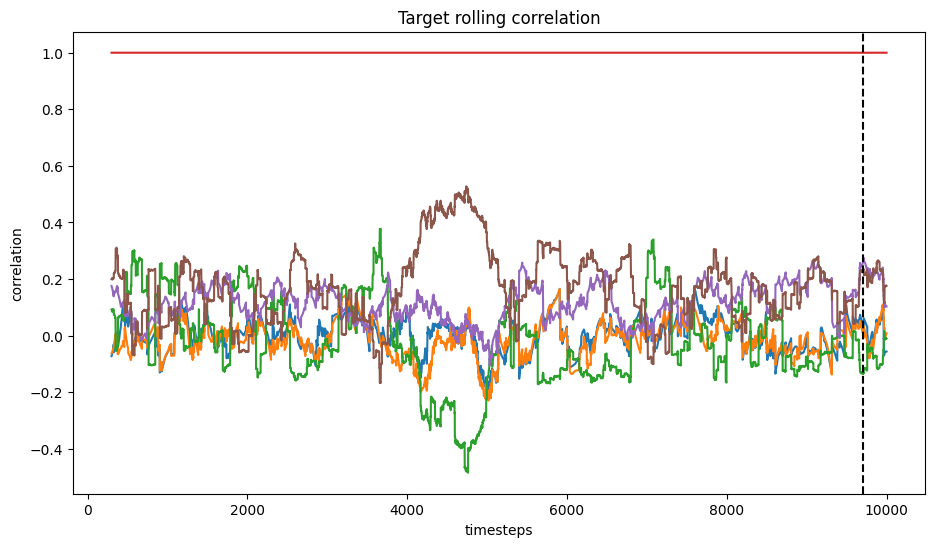

In [ ]:
### PLOT DBSCAN DETECTED ANOMALIES ###
roll_corr = filtered_df.rolling(300).corr()

for ano_loc,ano in network_ano.items():
    if ano is not None:
        for ano_feat in network_ano[ano_loc]:
            roll_corr[ano_feat].unstack().plot(
                legend=False, figsize=(11,6),
                title=f"{ano_feat} rolling correlation",
                ylabel='correlation', xlabel='timesteps'
            )
            plt.axvline(ano_loc, linestyle='--', c='black')
            plt.show()